[← Back to Index](https://makeabilitylab.github.io/physcomp/signals)

# Overview
In this Notebook, we are going to setup the framework for using a feature-based, [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) model to classify our gesture sets. While in the last assignment you built up familiarity with the SciPy libraries and an initial understanding of shape-based gesture classification, in this Notebook you will begin to learn:
- How to use [Scikit-learn](https://scikit-learn.org/), one of the most popular open-source machine learning libraries in the world
- How to rethink the classification problem not just in terms of signal **shapes** (as before) but in terms of signal **features**. You will brainstorm, visualize, and analyze both time-domain and frequency-domain features extracted from the gesture accelerometer data and learn how to find and then use potentially promising features in your classifier
- How to setup a classification experiment using Scikit-learn (you don't have to rely on your own k-fold cross validation code, for example)
- How to use some of the built-in supervised learning models in Scikit-learn to classify gestures

## Scikit learn

We are going to shift from using our own classifiers and experimental testbed (say goodbye to our custom `gesturerec.experiments` library) to a popular open-source machine learning library called [Scikit-learn](https://scikit-learn.org/stable/) ([code repo](https://github.com/scikit-learn/scikit-learn)). Scikit-learn (or sometimes called sklearn) started as a Google Summer of Code project and its name "SciKit" stems from using the [SciPy](https://www.scipy.org/) libraries as its foundation (though its development was and is independent).

We chose Scikit-learn as our primary machine learing library because:
- It is built on NumPy, SciPy, and matplotlib (so you need not learn another set of Python libraries)
- It is one of the most popular machine learning libraries in the world. On GitHub, for example, it has 25k+ commits and 40.8k stars ([link](https://github.com/scikit-learn/scikit-learn)). Building familiarity and comfort with Scikit-learn will not only increase your understanding of applied machine learning but also allow you to more easily use other machine learning toolkits in the future (*e.g.,* [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/)).

While this Notebook will cover some initial, core introductory concepts of using Scikit-learn—particularly for a gesture dataset—we are only scratching the surface of possibilities. You may want to consult the official [Scikit-learn tutorials](https://scikit-learn.org/stable/tutorial/index.html) either before or after working through this Notebook. Because of Scikit's popularity, there are also numerous (wonderful) tutorials online.

## Your TODOs

As before, you should use this Notebook as your template for the A4 assignment. We expect that you will read through and interact with cells sequentially. To help guide where you need to work, we've added "TODOs"—so search for that word. :)

# Imports

In [200]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis

from gesturerec.data import SensorData
from gesturerec.data import GestureSet

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold

# Import Pandas: https://pandas.pydata.org/
import pandas as pd

# Import Seaborn: https://seaborn.pydata.org/
import seaborn as sns

# Utility functions

In [62]:
def display_tables_side_by_side(df1, df2, n = None, df1_caption = "Caption table 1", df2_caption = "Caption table 2"):
    '''Displays the two tables side-by-side'''
    
    if n is not None:
        df1 = df1.head(n)
        df2 = df2.head(n)
    
    # Solution from https://stackoverflow.com/a/50899244
    df1_styler = df1.style.set_table_attributes("style='display:inline; margin:10px'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
def print_folds(cross_validator, X, y_true, trial_indices):
    '''Prints out the k-fold splits'''
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y_true[i], trial_indices[i]))
        fold_cnt += 1
        
def display_folds(cross_validator, X, y_true, trial_indices):
    map_fold_to_class_labels = dict()
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        
        class_labels = []
        for i in test_index:
            class_labels.append(f"{y_true[i]} {trial_indices[i]}")
        
        map_fold_to_class_labels[f"Fold {fold_cnt}"] = class_labels
        fold_cnt += 1
    
    df = pd.DataFrame(map_fold_to_class_labels)
    display(df)


def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # JonTODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    # SciPy's find_peaks supports this, so would be straightforward to implement
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

def plot_feature_1d(gesture_set, extract_feature_func, title = None, use_random_y_jitter = True,
                   xlim = None):
    '''
    Plots the extracted feature on a 1-dimensional plot. We use a random y-jitter 
    to make the values more noticeable
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    use_random_y_jitter: provides a random y jitter to make it easier to see values
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 3))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func(trial.accel) for trial in trials)
        y = None
        
        if use_random_y_jitter:
            y = np.random.rand(len(x))
        else:
            y = np.zeros(len(x))
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.ylim((0,3))
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if use_random_y_jitter:
        plt.ylabel("Ignore the y-axis")
        
    plt.legend(bbox_to_anchor=(1,1))   
    
    if title is None:
        title = f"1D plot of {extract_feature_func.__name__}"
    
    plt.title(title)
    plt.show()
    
def plot_feature_2d(gesture_set, extract_feature_func1, extract_feature_func2,
                    xlabel = "Feature 1", ylabel = "Feature 2",
                    title = None, xlim = None):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 5))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)

        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)
           
    plt.legend(bbox_to_anchor=(1,1))   
    
    plt.title(title)
    plt.show()

def plot_bar_graph(d, title=None, ylabel=None, xlabel=None):
    '''
    Plots a bar graph of of the values in d (with the keys as names)
    '''
    
    sorted_tuple_list = sorted(d.items(), key=lambda x: x[1])
    n_groups = len(d)

    sorted_keys = [] 
    sorted_values = [] 
    for k, v in sorted_tuple_list:
        sorted_keys.append(k)
        sorted_values.append(v)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    plt.figure(figsize=(12, fig_height))
    indices = np.arange(len(sorted_keys))

    plt.grid(zorder=0)
    bars = plt.barh(indices, sorted_values, alpha=0.8, color='b', zorder=3)
    
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.xlim(0, sorted_values[-1] * 1.1)
    plt.title(title)
    plt.yticks(indices, sorted_keys)
    
    for i, v in enumerate(sorted_values):
        plt.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    

    plt.tight_layout()
    plt.show()
    
def plot_signals(gesture_set, signal_var_names = ['x', 'y', 'z']):
    '''Plots the gesture set as a grid given the signal_var_names'''
    num_rows = len(gesture_set.map_gestures_to_trials)
    num_cols = len(signal_var_names)
    row_height = 3.5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    for row, gesture_name in enumerate(gesture_set.get_gesture_names_sorted()):
        gesture_trials = gesture_set.get_trials_for_gesture(gesture_name)

        for trial in gesture_trials:
            for col, signal_var_name in enumerate(signal_var_names):
                s = getattr(trial.accel, signal_var_name)       
                axes[row][col].plot(s, alpha=0.7, label=f"Trial {trial.trial_num}")

                axes[row][col].set_title(f"{gesture_name}: {signal_var_name}")
                axes[row][col].legend()

    fig.tight_layout(pad=2)

def plot_signals_aligned(gesture_set, signal_var_names = ['x', 'y', 'z'], title_fontsize=8):
    '''Aligns each signal using cross correlation and then plots them'''
    num_rows = len(gesture_set.map_gestures_to_trials)
    num_cols = len(signal_var_names)
    row_height = 3.5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    for row, gesture_name in enumerate(gesture_set.get_gesture_names_sorted()):
        gesture_trials = gesture_set.get_trials_for_gesture(gesture_name)

        for col, signal_var_name in enumerate(signal_var_names):
            
            # Find the maximum length signal. We need this to pad all
            # signals to the same length (a requirement of cross correlation)
            signal_lengths = []
            for trial in gesture_trials:
                s = getattr(trial.accel, signal_var_name) 
                signal_lengths.append(len(s))
            max_trial_length = np.max(signal_lengths)
            
            # Actually pad the signals
            signals = []
            for trial in gesture_trials:
                s = getattr(trial.accel, signal_var_name) 
                
                padding_length = max_trial_length - len(s)
                if padding_length > 0:
                    pad_amount_left = (math.floor(padding_length/2.0))
                    pad_amount_right = (math.ceil(padding_length/2.0))
                    padded_s = np.pad(s, (pad_amount_left, pad_amount_right), mode = 'mean')
                    signals.append(padded_s)
                else:
                    signals.append(s)
            
            # Grab a signal to align everything to. We could more carefully choose
            # this signal to be the closest signal to the average aggregate... but this
            # should do for now
            golden_signal = signals[0] # the signal to align everything to
            
            # Align all the signals and store them in aligned_signals
            aligned_signals = [golden_signal]
            for i in range(1, len(signals)):
                a = golden_signal
                b = signals[i]
                correlate_result = np.correlate(a, b, 'full')
                best_correlation_index = np.argmax(correlate_result)
                shift_amount = (-len(a) + 1) + best_correlation_index
                b_shifted_mean_fill = shift_array(b, shift_amount, np.mean(b))
                aligned_signals.append(b_shifted_mean_fill)
            
            # Plot the aligned signals
            for signal_index, trial in enumerate(gesture_trials):
                s = aligned_signals[signal_index]
                axes[row][col].plot(s, alpha=0.7, label=f"Trial {trial.trial_num}")

                axes[row][col].set_title(f"Aligned {gesture_name}: {signal_var_name}", fontsize=title_fontsize)
                axes[row][col].legend()           

    fig.tight_layout(pad=2)
    
def shift_array(arr, shift_amount, fill_value = np.nan):
    '''Shifts the array either left or right by the shift_amount (which can be negative or positive)
     
       From: https://stackoverflow.com/a/42642326
    '''
    result = np.empty_like(arr)
    if shift_amount > 0:
        result[:shift_amount] = fill_value
        result[shift_amount:] = arr[:-shift_amount]
    elif shift_amount < 0:
        result[shift_amount:] = fill_value
        result[:shift_amount] = arr[-shift_amount:]
    else:
        result[:] = arr
    return result

# Load the data
These cells are the same as for the [Shape Matching](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html) notebook. You should not need to edit them, only run them.

In [4]:
# Load the data
#root_gesture_log_path = './GestureLogsADXL335'
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['AGestures', 'AlexandraGestures', 'AlexisGestures', 'AnjaliGestures', 'BrettGestures', 'BryanGestures', 'ClayGestures', 'DustinGestures', 'EmmaGestures', 'JaeHGestures', 'JasonGestures', 'JonGestures', 'JuliaBGestures', 'JustinGestures', 'MattCGestures', 'MikaelGestures', 'NanGestures', 'NeilGestures', 'NickGestures', 'NooseGestures', 'OjasviGestures', 'Paf2Gestures', 'SamuelRGestures', 'ShaunGestures', 'StacyGestures', 'ThweidGestures', 'WolfGestures']
Creating a GestureSet object for path './GestureLogs\AGestures'
Found 55 csv files in ./GestureLogs\AGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 t

Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 889 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.5s

Creating a GestureSet object for path './GestureLogs\JuliaBGestures'
Found 55 csv files in ./GestureLogs\JuliaBGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all 

Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Custom' Trial 4 with 357 sensor events.
Avg samples/sec across 55 sensor files: 91.4
Avg sample length across 55 sensor files: 2.1s

Creating a GestureSet object for path './GestureLogs\StacyGestures'
Found 55 csv files in ./GestureLogs\StacyGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [5]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 27 gesture sets:
 AGestures with 55 trials
 AlexandraGestures with 55 trials
 AlexisGestures with 55 trials
 AnjaliGestures with 55 trials
 BrettGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 DustinGestures with 55 trials
 EmmaGestures with 55 trials
 JaeHGestures with 55 trials
 JasonGestures with 55 trials
 JonGestures with 55 trials
 JuliaBGestures with 55 trials
 JustinGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 NanGestures with 55 trials
 NeilGestures with 55 trials
 NickGestures with 55 trials
 NooseGestures with 55 trials
 OjasviGestures with 55 trials
 Paf2Gestures with 55 trials
 SamuelRGestures with 55 trials
 ShaunGestures with 55 trials
 StacyGestures with 55 trials
 ThweidGestures with 55 trials
 WolfGestures with 55 trials
The selected gesture set is: JonGestures


# Preprocess the data

You may or may not want to revisit how you preprocess your data. Remember: we are using a fundamentally different approach for classification, so it's worth reconsidering your full data analysis pipeline.

In [6]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    # TODO: write your preprocessing code here. We'll do something very simple for now,
    
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

# Feature exploration

We are going to start this adventure, as we always should, by trying to better understand our signals and the features we plan to extract.

Our goal is to brainstorm and identify highly discriminable attributes of each gesture class that we may be able to leverage in our feature-based classifiers.

While our classifiers will work in high-dimensions, humans, at best can really only visualize and interpret at most 3-dimensions.

So, we're going to start by graphing our features along 1-dimension. Yes, 1-dimension! To make it easier to see patterns in our data, we will add in a bit of y-jitter, so the graphs below may appear 2-dimensional—but they are not. Ignore the y-axis for these 1D plots.

## Time domain

Let's explore some time domain features first. 

### Visualizing time-domain signals
Just like with shape-matching, let's begin by graphing the time-domain signals.

#### Visualizing raw x, y, z, and mag

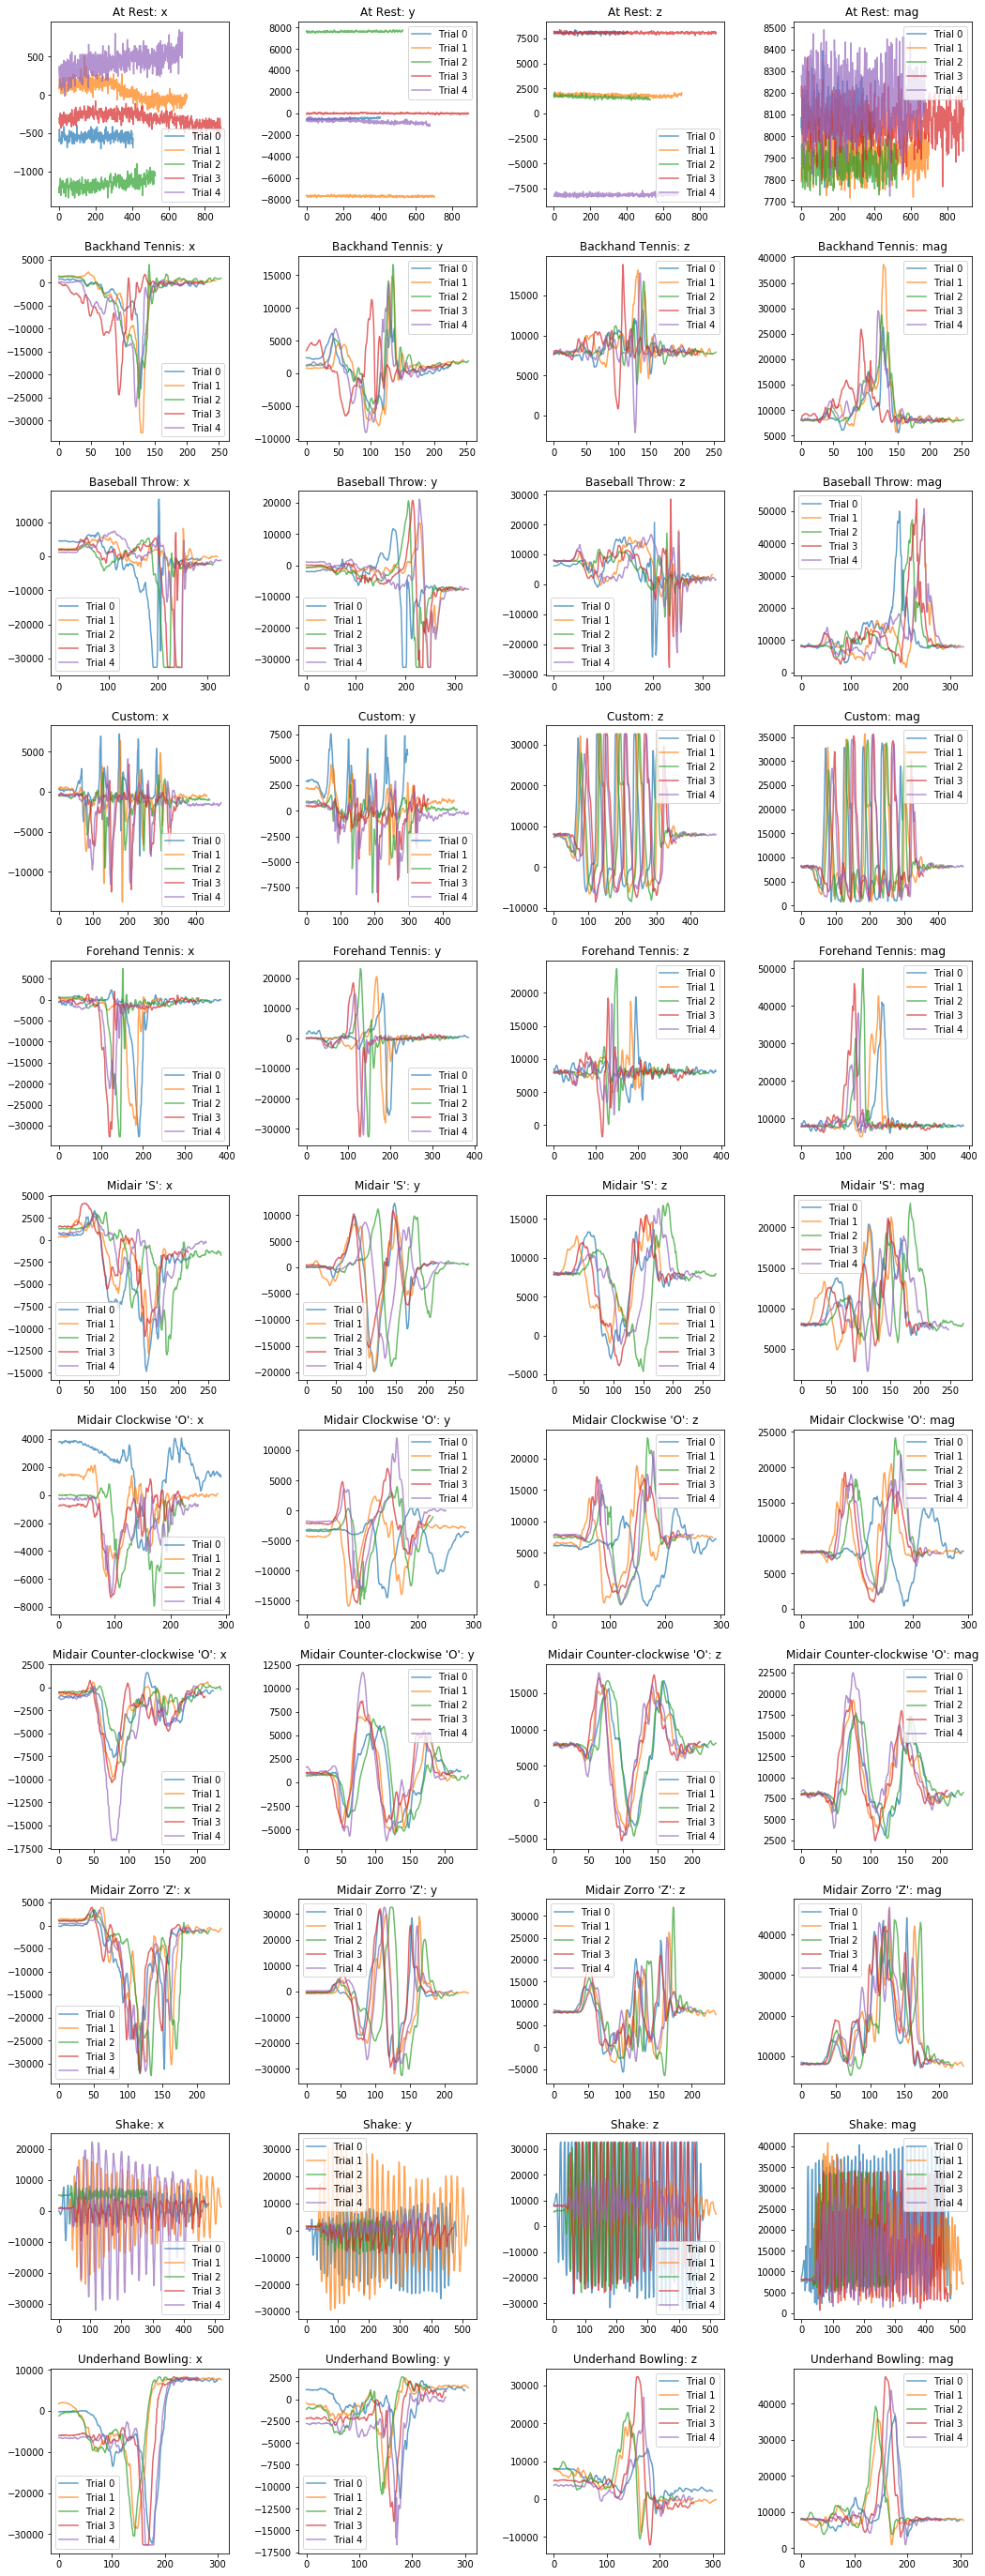

In [7]:
plot_signals(selected_gesture_set, ['x', 'y', 'z', 'mag'])

#### Visualizing aligned raw signals

It may be easier to pick out interesting patterns with the signals aligned.

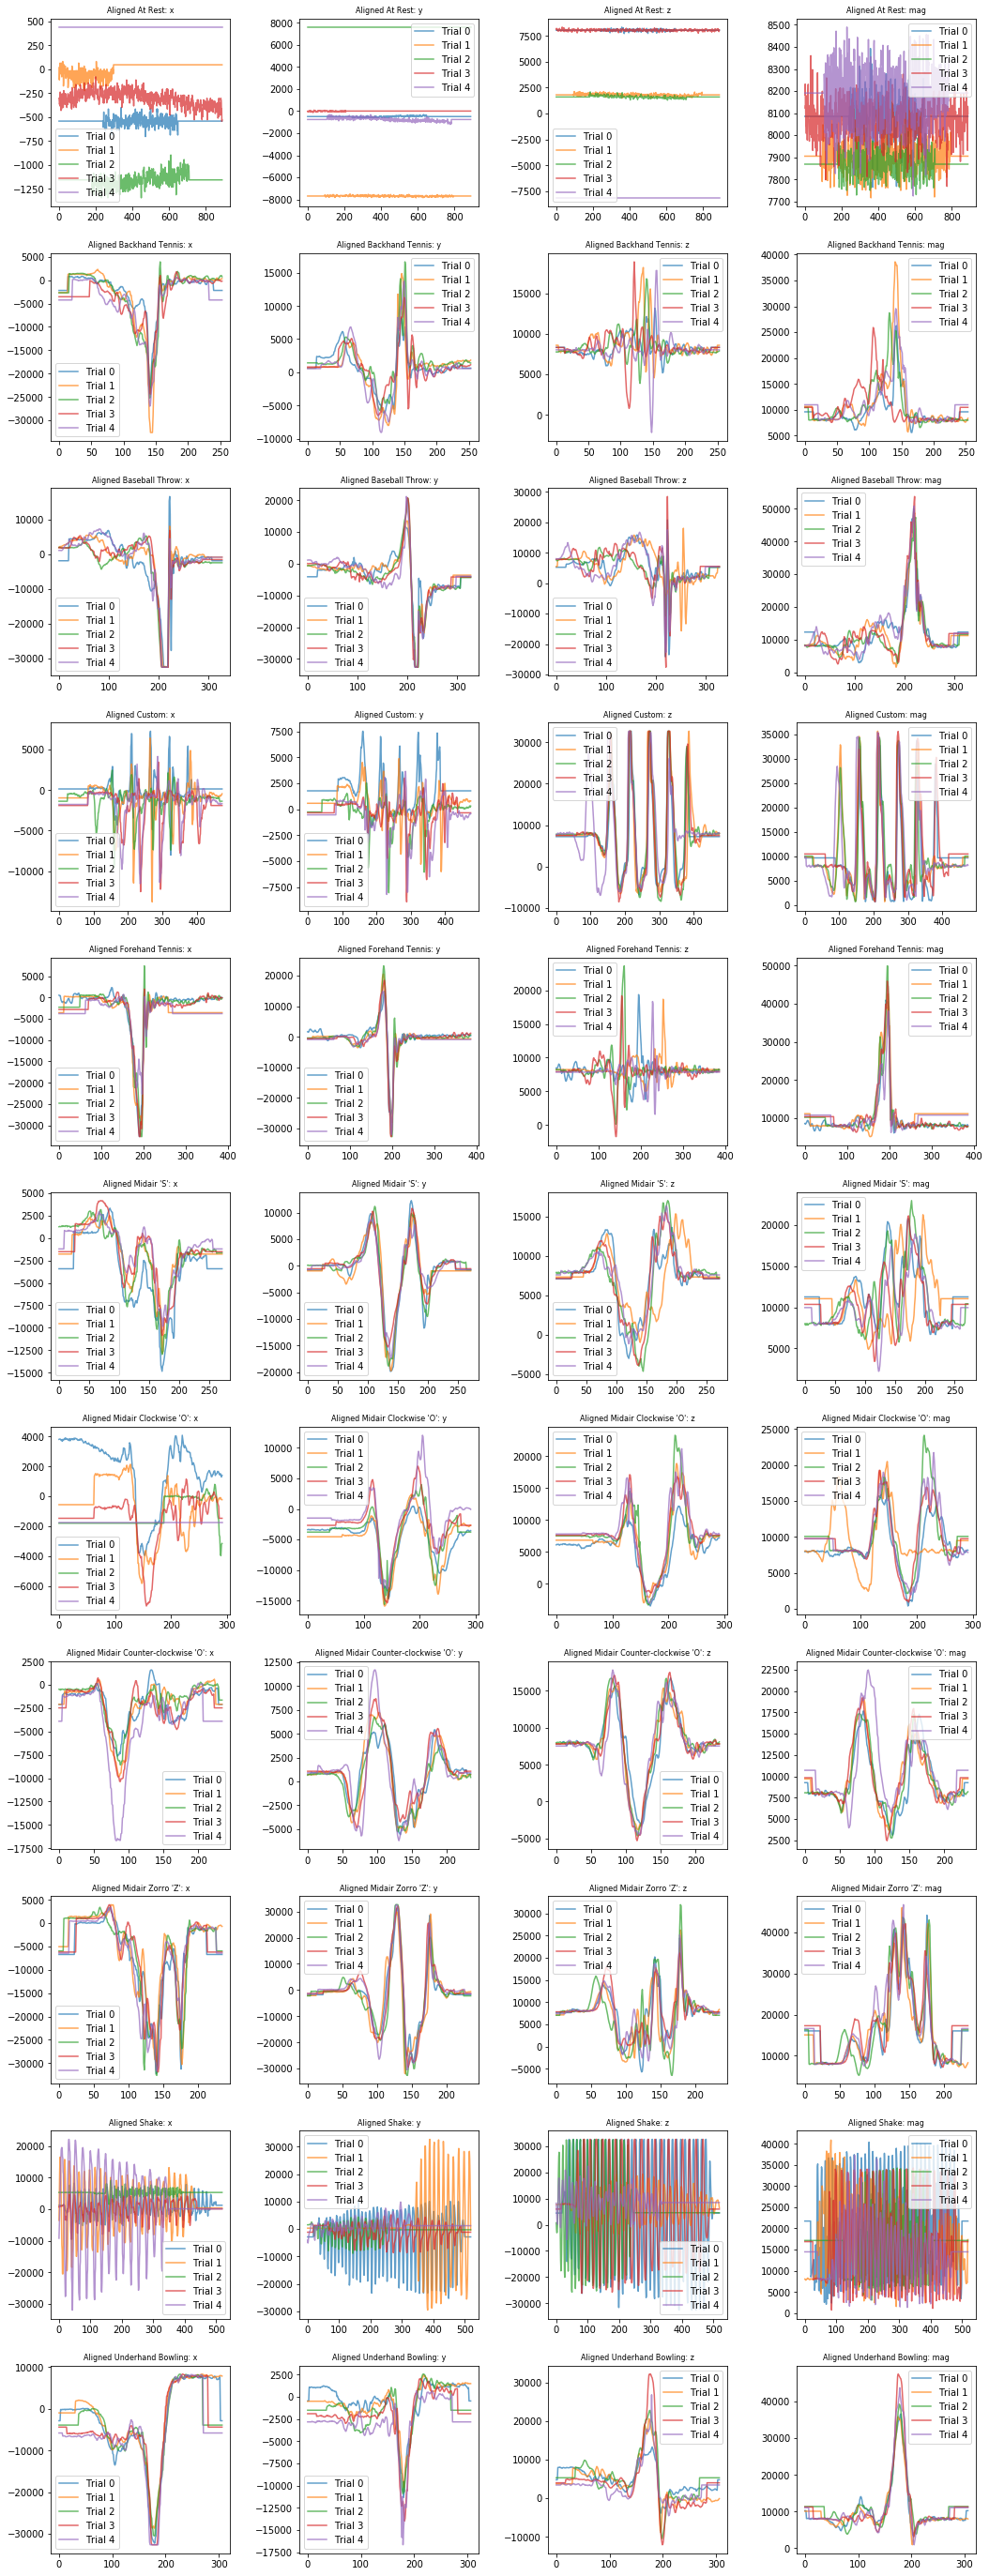

In [8]:
plot_signals_aligned(selected_gesture_set, ['x', 'y', 'z', 'mag'])

#### Visualizing processed x, y, z, and mag signals

Now let's visualize the processed signals.

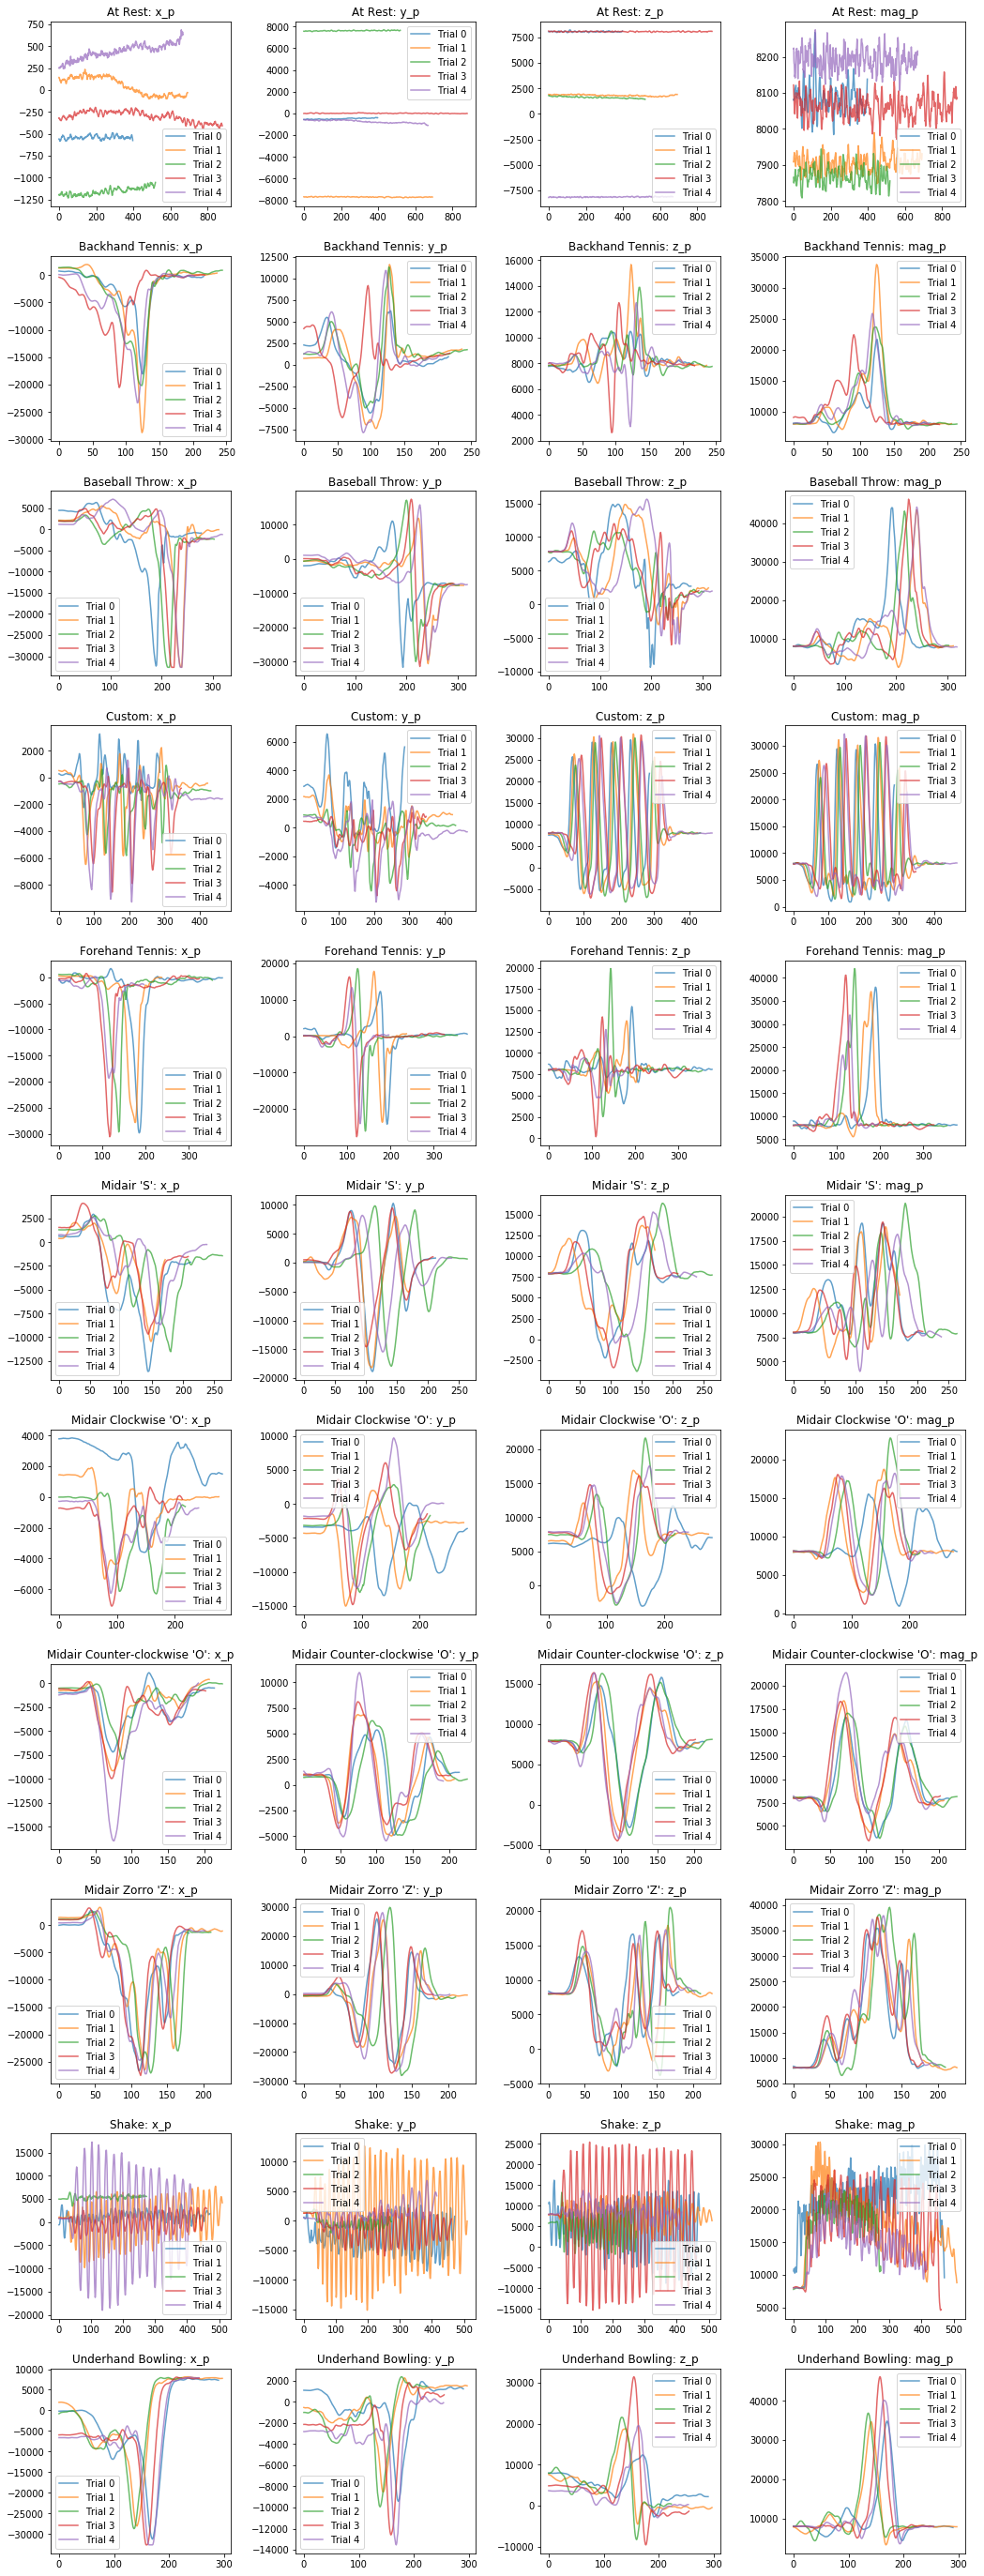

In [9]:
plot_signals(selected_gesture_set, ['x_p', 'y_p', 'z_p', 'mag_p'])

#### Visualzing aligned processed signals

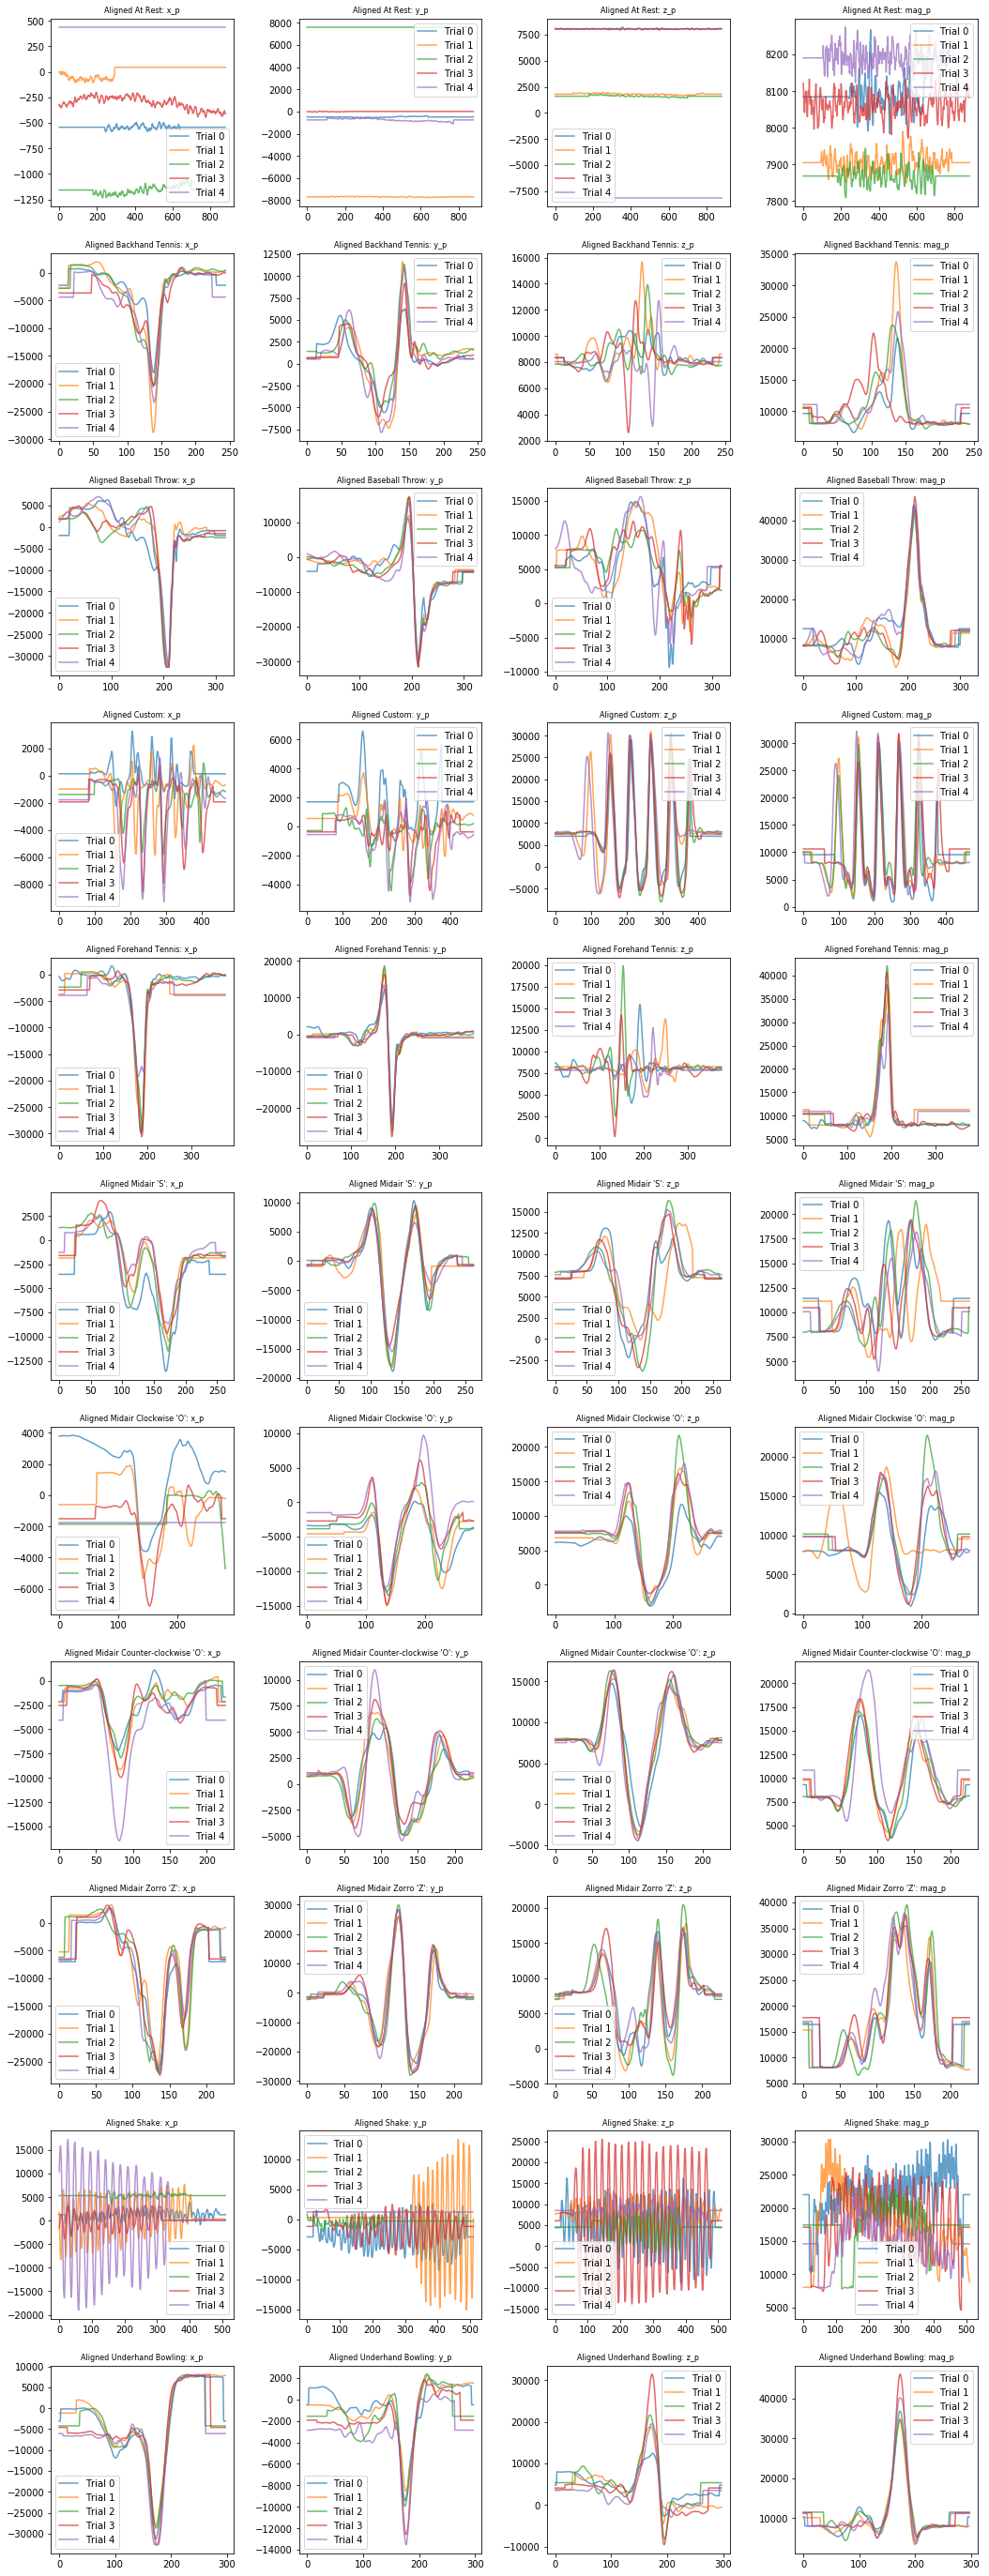

In [10]:
plot_signals_aligned(selected_gesture_set, ['x_p', 'y_p', 'z_p', 'mag_p'])

### Extract and visualize time-domain features

After reviewing the above graphs and thinking about what features we might be able to extract from the time-domain signals, let's extract and plot some specific time-domain features. We've created a helper function called `plot_feature_1d`, which will plot a specified feature in a 1-dimensional graph.

Let's check it out!

#### Feature: standard deviation of accel mag

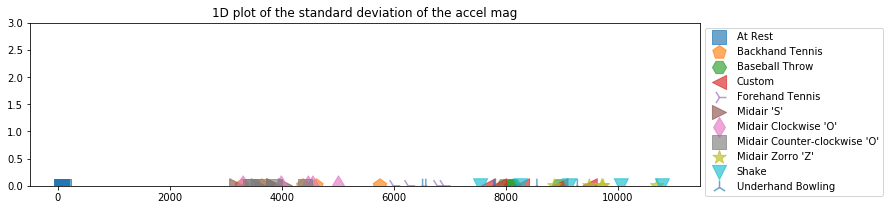

In [11]:
# Write a simple anonymous function that takes in an accel.trial and returns
# an extracted feature. In this case, the standard deviation of the magnitude
extract_feature_std_mag = lambda accel_trial: np.std(accel_trial.mag)

# We could also have done the following but it's slightly messier for our purposes
# def extract_feature_std_mag(accel_trial):
#    return np.std(accel_trial.mag)

# Plot the feature (but with no y-jitter)
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, 
                title = graph_title, use_random_y_jitter = False)

To make it easier to see the 1-dimensional spacing, by default, we add in a random y-jitter (which is a common graphing trick). But just remember, the y-values here are meaningless.

So, let's graph the same thing but with the random y jitter turned on.

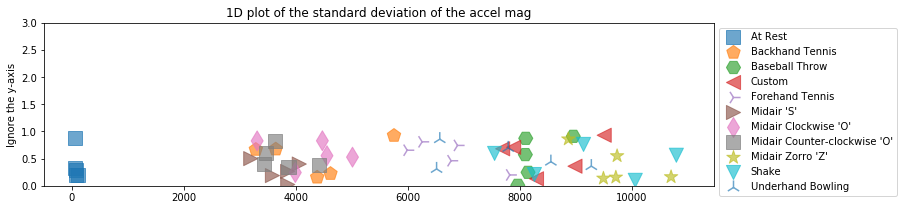

In [12]:
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, title = graph_title)

Even with just one feature and a 1D plot, we can begin to see some separation between gestures:
- Unsurprisingly, the *At Rest* gesture has the least amount of deviation
- And then there are ~2 or maybe 3 other groups: a middle group of *Clockwise 'O'*, *Counter-clockwise 'O'*, *Backhand Tennis*, a less defined intermediate group of *Forehand Tennis* and *Underhand Bowling*, and a more extreme group of *Shake*, *Midair Zorro 'Z'*, and *Baseball Throw*
    

#### Feature: maximum accel mag

How about the **maximum** of the accelerometer magnitude in each gesture trial? Is there discriminable information there?

Let's check it out!

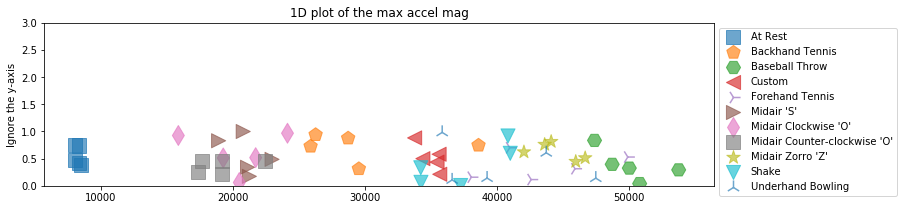

In [13]:
extract_feature_max_mag = lambda accel_trial: np.max(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_max_mag, 
                title = "1D plot of the max accel mag")

What do you observe? Again, this feature seems useful—at least for discriminating some gestures like *At Rest* and *Baseball Throw*. As before, there are also clear clusters that are emerging.

#### Feature: num peaks
Finally, let's count the number of peaks (given a certain height and distance threshold). Unlike our other input features thus far, count data is discrete (not continuous), is limited to non-negative values, and will have a different distribution.

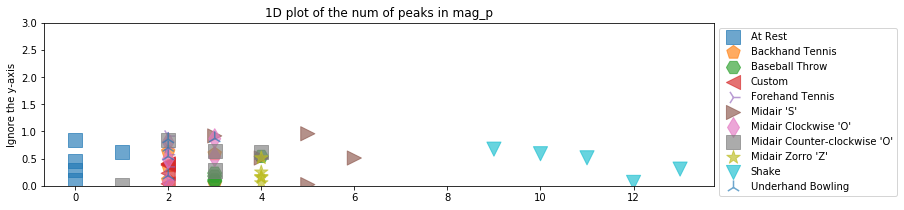

In [85]:
def extract_feature_num_peaks_mag_p(accel_trial):
    mag_p = sp.signal.detrend(accel_trial.mag_p)
    
    # height is the height of the peaks and distance is the minimum horizontal distance
    # (in samples) between peaks. Feel free to play with these thresholds
    peak_indices, peak_properties = sp.signal.find_peaks(mag_p, height=100, distance=5)
    return len(peak_indices)
    
plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_mag_p, 
                title = "1D plot of the num of peaks in mag_p")

#### Brainstorm and plot your own time domain features

Below, brainstorm and plot your own time domain features. We've provided an initial list of features to try but dig into the signals, think about what makes each gesture class unique, and try to extract and leverage those unique aspects as features. 

You could extract (many of) these features either from the raw accelerometer signal (*e.g.,* `x`, `y`, `z`, and `mag`) or a preprocessed version.

- Signal length
- Descriptive statistics of each axis (x, y, z) + magnitude, including mean, median, standard deviation
- Peak counting (raw number of peaks, number of peaks over certain threshold)
- Horizontal distance between peaks, avg vertical distance between peaks
- Number of zero crossings
- Other things! Read papers, brainstorm, visualize!

Once you've exhausted our list and your own mind, consult the web. Use [Google Scholar](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=gesture+recognition+accelerometer&btnG=), for example, to find gesture recognition papers: what features did they use?

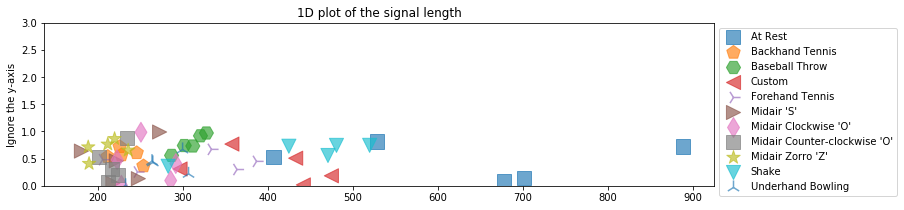

In [14]:
# We'll start with another one here: signal length but add more!

extract_feature_signal_length = lambda accel_trial: len(accel_trial.x)
plot_feature_1d(selected_gesture_set, extract_feature_signal_length, 
                title = "1D plot of the signal length")

## Frequency domain

Of course, there may also be discriminable information in the frequency domain. If you haven't already, complete our [Frequency Analysis](https://makeabilitylab.github.io/physcomp/signals/FrequencyAnalysis/index.html) lesson before moving forward.

Just as we brainstormed time domain features, how about features in the frequency domain, such as:
- The top frequency (*i.e.,* the frequency with the highest amplitude in the signal)
- The top N frequencies (overall or within some frequency band)
- The lowest/highest frequency (over some amplitude threshold)
- Number of frequency peaks (over a certain amplitude threshold)
- Avg value of frequency peaks
- Or perhaps a sliding window that breaks up the signal into chunks and extracts frequency information over each chunk
- And many others...

### Visualizing frequency information 

Let's start—as we always should—by plotting our signals and exploring some initial stats.

Below, we plot a visualization grid where each column is a gesture trial and rows alternate between the time domain and frequency domain versions of the `mag` for that gesture.

IntProgress(value=0, max=22)

Selected gesture set: JonGestures


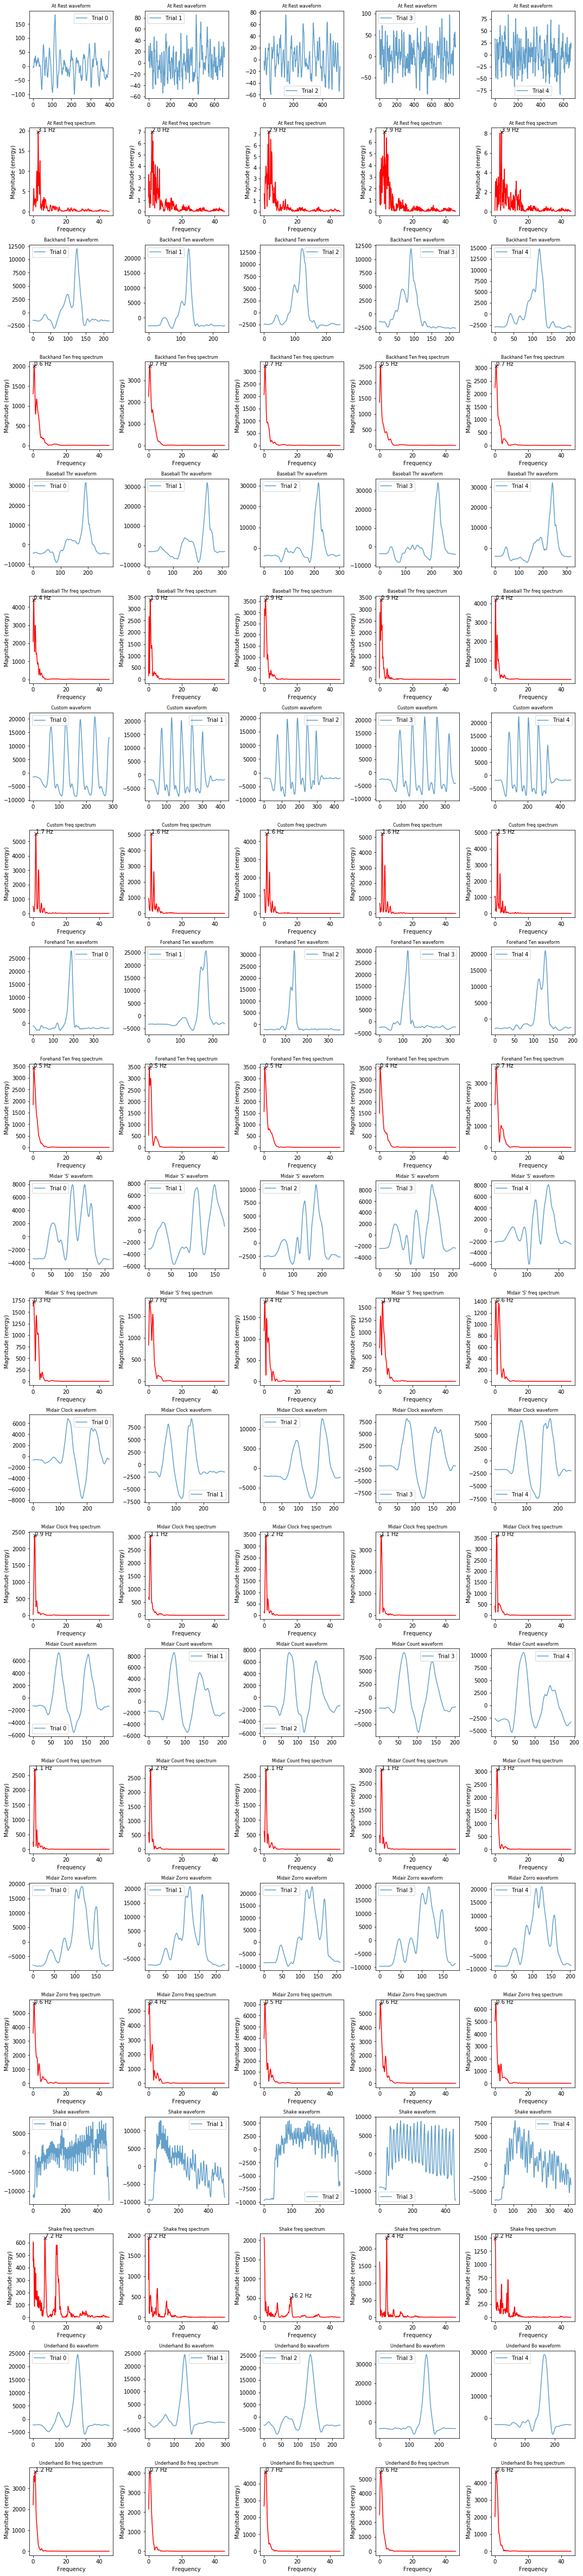

In [15]:
# This cell will take a bit of time not because of the frequency analysis but because
# of preparing the large matplotlib image
import IPython.display as ipd
import ipywidgets

num_cols = 5 # 1 col for each gesture trial 
num_rows = selected_gesture_set.get_num_gestures() * 2 # 1 for waveform, 1 for frequency per gesture
row_height = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))

index = 0
sampling_rate = 92 # roughly 92
progress_bar = ipywidgets.IntProgress(value=0, min=0, max=num_rows)
ipd.display(progress_bar)
title_font_size = 8
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    for trial in gesture_trials:
        s = trial.accel.mag_p # change this to visualize/explore other signals
        ax = axes[index][trial.trial_num]
        
        # remove "DC offset" to perform FFT
        s_removed_offset = s - np.mean(s)
        
        ax.plot(s_removed_offset, alpha=0.7, label=f"Trial {trial.trial_num}")
        ax.set_title(f"{gesture_name[0:12]} waveform", fontsize= title_font_size)
        ax.legend()
        
        sampling_rate = math.ceil(trial.accel.sampling_rate)
        ax = axes[index + 1][trial.trial_num]
        spectrum, freqs_of_spectrum, line = ax.magnitude_spectrum(s_removed_offset, Fs = sampling_rate, 
                                                        color='r', pad_to = 4 * len(s))
        ax.set_title(f"{gesture_name[0:12]} freq spectrum", fontsize= title_font_size)
        
        # Annotate the top freq (by amplitude) on each graph
        top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, freqs_of_spectrum, spectrum)
        top_freq = top_n_freq_with_amplitudes[0][0]
        top_amplitude = top_n_freq_with_amplitudes[0][1]
        ax.plot(top_freq, top_amplitude, marker="x", color="black", alpha=0.8)
        ax.text(top_freq, top_amplitude, f"{top_freq:0.1f} Hz", color="black")
      
    index = index + 2 
    progress_bar.value = index
    
fig.tight_layout(pad=1)

print(f"Selected gesture set: {selected_gesture_set.name}")

### Feature: top frequency
As one example, let's extract the most prominent (highest-amplitude) frequency for each gesture using the magnitude part of the accelerometer signal.

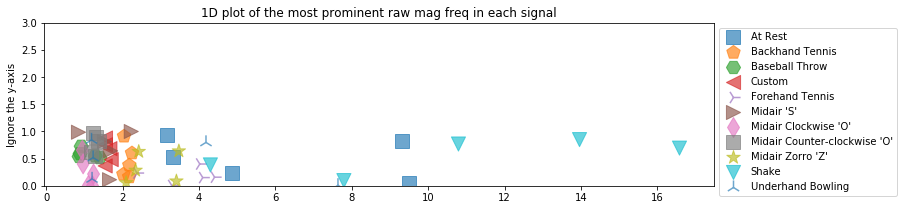

In [16]:
def extract_feature_top_mag_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq, 
                title = "1D plot of the most prominent raw mag freq in each signal")

You might be surprised to see *At Rest's* position in the graph. This is because we do not take into account the *strength* of the frequency component for each signal. The identified frequencies in *At Rest* are low amplitude (and largely noise).

To control for this, we can add in a parameter to `get_top_n_frequency_peaks` to filter out identified frequencies of less than a certain amplitude coefficient. In this case, let's try `500` but you should experiment with any thresholds used in your code.

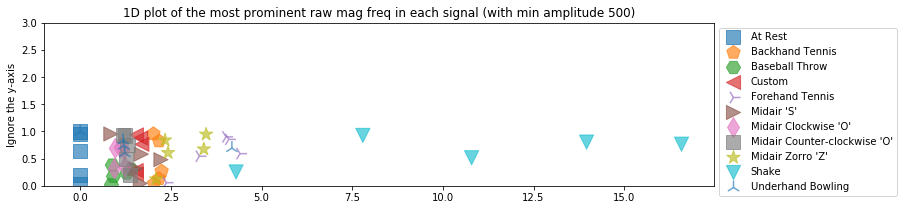

In [17]:
def extract_feature_top_mag_freq2(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)")

We are able to see roughly four groupings here:
- The *At Rest* group
- A second cluster with frequencies between ~0.5 and 2.5 Hz
- Possibly a third cluster with *Zorro* and *Forehand Tennis* between ~2.5 and 5 Hz
- And another clear outlier cluster for *Shake* with freq between ~5-15 Hz

Let's zoom into the x-axis a bit to explore the middle cluster more closely.

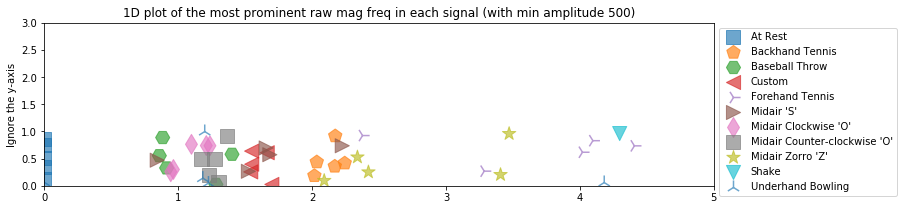

In [18]:
plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)",
                xlim = (0, 5))

We can, of course, perform frequency analyses on any other signal—be it `x`, `y`, `z`, `mag` or some processed version. For example, here's a frequency analysis of a preprocessed `mag_p` signal.

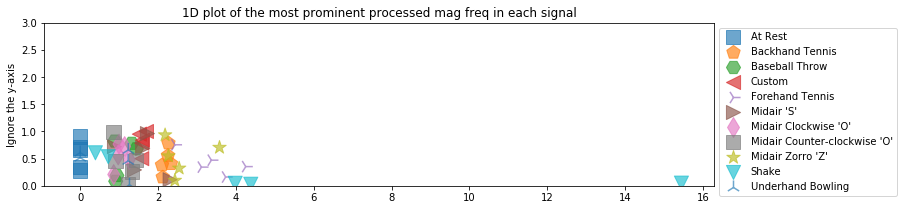

In [19]:
def extract_feature_top_mag_p_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_p_freq, 
                title = "1D plot of the most prominent processed mag freq in each signal")

### Brainstorm and plot your own frequency domain features

What other features can you think of for the frequency domain?

In [20]:
# TODO: Graph additional frequency-based features

## 2-dimensional explorations

OK, now that we've built up some familiarity with feature extraction and how these features may enable us to discriminate gestures, let's plot various combinations of them in 2D. Again, remember that our classifiers will (often) work in N-dimensions where N is the number of features. But it's just not possible for us to visualize all of our features at once in an N-dimensional graph.

But at least we're going from 1D to 2D, wee! :)

We'll begin by just randomly choosing some features to plot together: how about the standard deviation of the accel `mag` and the max `mag`?

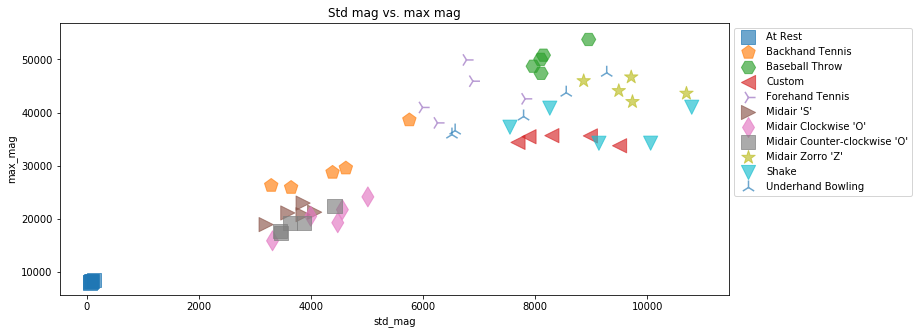

In [21]:
plot_feature_2d(selected_gesture_set, extract_feature_std_mag, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

Again, our goal here is to see clear clusters emerging—ideally where each cluster is composed of the same gesture class and the clusters themselves have clear separation.

Let's try another combination. How about the max `mag` frequency component (in frequency domain) and the max `mag` signal value (in the time domain).

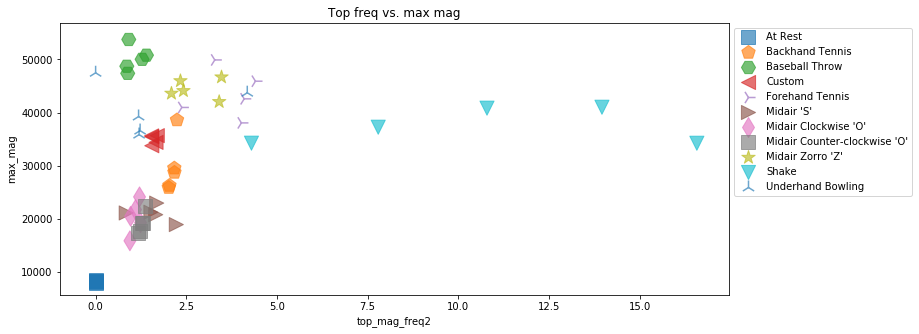

In [22]:
# plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_std_mag,
#                xlabel="extract_feature_top_mag_freq2", ylabel="max_mag", title="Std mag vs. max mag")

plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

Again, now it's up to you. Try graphing some feature combinations below.

In [23]:
# TODO: Write some of your own 2D plot explorations

## Pandas

At risk of introducing too many frameworks and libraries in this course (I know!), we had to bring in one more: [pandas](https://pandas.pydata.org/)—one of the most popular open-source data analysis tools in data science. And pandas builds on and uses SciPy libraries.

Rest assured, we are *barely* going to use pandas. But we are going to use pandas [DataFrame](https://pandas.pydata.org/docs/getting_started/dsintro.html#dataframe) data structures, which are 2-dimensional tables a bit like a spreadsheet or an SQL table. They support querying, filtering, *etc.* but we mainly use them because it makes interacting with Scikit-learn easier (in our humble opinions, at least).

And again, don't worry. We show you everything you need to know below. You can certainly dive deeper, if you want. Knowing pandas gives you major data science street cred. :) 

While not necessary, you may want to check out the official [10-minute pandas tutorial](https://pandas.pydata.org/docs/getting_started/dsintro.html) or just dive in below.

### Create pandas DataFrame of features
Below, we build a pandas DataFrame table of our features. This is just a small playground. The *real* feature extraction code that we use in our classification experiments is found below in the sub-section entitled [Feature extraction code](#Feature-extraction-code).

In [133]:
df = None
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    
    for trial in trials:
        features = dict()
        features["gesturer"] = selected_gesture_set.name
        features["gesture"] = gesture_name
        features["trial_num"] = trial.trial_num
        features["signal_length (samples)"] = extract_feature_signal_length(trial.accel)
        features["signal_length (secs)"] = trial.accel.length_in_secs
        features["num_peaks_mag_p"] = extract_feature_num_peaks_mag_p(trial.accel)
        features["max_mag"] = extract_feature_max_mag(trial.accel)
        features["max_mag_p"] = np.max(trial.accel.mag_p)
        features["std_mag"] = extract_feature_std_mag(trial.accel)
        features["top_mag_freq"] = extract_feature_top_mag_freq2(trial.accel)
        
        if df is None:
            df = pd.DataFrame([features])
        else:
            df = df.append(features, ignore_index=True)

# Calling display on a DataFrame creates a pretty HTML-formatted table!
# Print out only the first 11 rows
display(df.head(n = 11))
gesture_col = df['gesture']

gesture        gesturer       max_mag     max_mag_p  \
0           At Rest  JustinGestures   8724.021091   8457.349213   
1           At Rest  JustinGestures   8514.856664   8325.357087   
2           At Rest  JustinGestures   8415.117824   8330.091971   
3           At Rest  JustinGestures   8479.366014   8330.179809   
4           At Rest  JustinGestures   8477.342980   8290.683357   
5   Backhand Tennis  JustinGestures  33052.359916  29623.428203   
6   Backhand Tennis  JustinGestures  33412.742958  28039.765208   
7   Backhand Tennis  JustinGestures  33481.413590  27710.694280   
8   Backhand Tennis  JustinGestures  39652.461412  33705.870233   
9   Backhand Tennis  JustinGestures  40647.070251  36058.661160   
10   Baseball Throw  JustinGestures  38778.933662  36184.933752   

    num_peaks_mag_p  signal_length (samples)  signal_length (secs)  \
0                 1                      332                 3.640   
1                 0                      359                 3.935   
2                 0                      264                 2.892   
3                 0                      325                 3.562   
4                 0                      340                 3.724   
5                 2                      137                 1.496   
6                 3                      156                 1.706   
7                 2                      148                 1.615   
8                 3                      180                 1.969   
9                 2                      190                 2.078   
10                4                      172                 1.880   

        std_mag  top_mag_freq  trial_num  
0     80.507973      0.000000          0  
1     67.867378      0.000000          1  
2     65.842553      0.000000          2  
3     66.285355      0.000000          3  
4     63.019355      0.000000          4  
5   6290.304204      1.343066          0  
6   5592.212692      1.179487          1  
7   5826.532634      1.243243          2  
8   6661.684848      1.533333          3  
9   7066.580457      1.452632          4  
10  7188.497329      2.674419          0

### Pandas groupby
Similar to SQL, you can create groupings using the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function and then use [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) to generate descriptive stats for each gesture (applied across all trials).

In [134]:
display(df.groupby('gesture').describe())

max_mag                                           \
                               count          mean          std           min   
gesture                                                                         
At Rest                          5.0   8522.140915   118.426301   8415.117824   
Backhand Tennis                  5.0  36049.209625  3763.289350  33052.359916   
Baseball Throw                   5.0  44096.550144  3949.240907  38778.933662   
Custom                           5.0  48050.053609  1779.717724  46311.518394   
Forehand Tennis                  5.0  50570.578099  3679.835374  47238.628261   
Midair 'S'                       5.0  14153.830917  2176.875275  11923.865145   
Midair Clockwise 'O'             5.0  19688.584409   948.204080  18165.954971   
Midair Counter-clockwise 'O'     5.0  17858.228241   973.002125  16651.980303   
Midair Zorro 'Z'                 5.0  53161.767523  3465.194411  47119.513750   
Shake                            5.0  35855.898539  2359.662461  33574.214868   
Underhand Bowling                5.0  40504.112830  3951.799445  37400.190802   

                                                                        \
                                       25%           50%           75%   
gesture                                                                  
At Rest                        8477.342980   8479.366014   8514.856664   
Backhand Tennis               33412.742958  33481.413590  39652.461412   
Baseball Throw                41248.788200  45232.962140  47563.048515   
Custom                        47135.796334  47270.932464  48690.100513   
Forehand Tennis               48573.475560  48967.032175  51539.616141   
Midair 'S'                    12760.840098  14081.645358  14387.443414   
Midair Clockwise 'O'          19434.883277  19952.263030  20442.183836   
Midair Counter-clockwise 'O'  16968.910867  18361.490136  18554.316371   
Midair Zorro 'Z'              53954.170775  54196.560776  54583.947824   
Shake                         34031.552418  35280.816317  37089.525422   
Underhand Bowling             38119.737250  38279.517656  41865.151905   

                                           max_mag_p                ...  \
                                       max     count          mean  ...   
gesture                                                             ...   
At Rest                        8724.021091       5.0   8346.732287  ...   
Backhand Tennis               40647.070251       5.0  31027.683817  ...   
Baseball Throw                47659.018202       5.0  38674.491454  ...   
Custom                        50841.920341       5.0  46361.504825  ...   
Forehand Tennis               56534.138359       5.0  46693.199927  ...   
Midair 'S'                    17615.360570       5.0  13056.384128  ...   
Midair Clockwise 'O'          20447.636929       5.0  18932.158801  ...   
Midair Counter-clockwise 'O'  18754.443527       5.0  17262.845847  ...   
Midair Zorro 'Z'              55954.644490       5.0  41514.571782  ...   
Shake                         39303.383671       5.0  24798.089948  ...   
Underhand Bowling             46855.966536       5.0  38081.730937  ...   

                             top_mag_freq           trial_num                 \
                                      75%       max     count mean       std   
gesture                                                                        
At Rest                          0.000000  0.000000       5.0  2.0  1.581139   
Backhand Tennis                  1.452632  1.533333       5.0  2.0  1.581139   
Baseball Throw                   2.674419  3.914894       5.0  2.0  1.581139   
Custom                           1.016575  1.039548       5.0  2.0  1.581139   
Forehand Tennis                  1.063584  5.075862       5.0  2.0  1.581139   
Midair 'S'                       1.577143  1.985612       5.0  2.0  1.581139   
Midair Clockwise 'O'             1.033708  2.314465       5.0  2.0  1.581139   
Midair

### Pairwise correlation

We can use Pandas to calculate a pairwise correlation between features. Often, we want features that have low (near zero) correlation with one another. If multiple features are highly correlated, then they will not improve our classification performance (and will also slow down training).

The function [`df.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) computes a pairwise correlation of columns (by default, using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which measures the linear correlation between two variables).

For more on understanding the relationship between your input features and the Pearson correlation, read this [article](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) from Machine Learning Mastery.

In [135]:
# Pop a few things off the dataframe, which we don't want to include
# in our correlation analysis
if 'trial_num' in df:
    df.pop("trial_num")
if 'gesture' in df:
    df.pop('gesture')
if 'gesturer' in df:
    df.pop('gesturer')

# Compute and show the pairwise correlation table
corr = df.corr()
display(corr)


max_mag  max_mag_p  num_peaks_mag_p  \
max_mag                  1.000000   0.967551         0.119004   
max_mag_p                0.967551   1.000000        -0.057563   
num_peaks_mag_p          0.119004  -0.057563         1.000000   
signal_length (samples) -0.371591  -0.430628         0.247713   
signal_length (secs)    -0.371519  -0.430627         0.247745   
std_mag                  0.943200   0.908335         0.285532   
top_mag_freq             0.452063   0.313787         0.674776   

                         signal_length (samples)  signal_length (secs)  \
max_mag                                -0.371591             -0.371519   
max_mag_p                              -0.430628             -0.430627   
num_peaks_mag_p                         0.247713              0.247745   
signal_length (samples)                 1.000000              0.999997   
signal_length (secs)                    0.999997              1.000000   
std_mag                                -0.285395             -0.285332   
top_mag_freq                           -0.123897             -0.123884   

                          std_mag  top_mag_freq  
max_mag                  0.943200      0.452063  
max_mag_p                0.908335      0.313787  
num_peaks_mag_p          0.285532      0.674776  
signal_length (samples) -0.285395     -0.123897  
signal_length (secs)    -0.285332     -0.123884  
std_mag                  1.000000      0.524219  
top_mag_freq             0.524219      1.000000

### Plot the pairwise correlation

Given that it's not particularly easy to find trends in a large table, we can plot this pairwise correlation table graphically and then refer back to the table for actual data.

Generally, we want to eliminate input features that are highly correlated (so close to either -1 or 1).

From the visualization and table, we can see (unsurprisingly) that the two features signal_length (samples) and signal_length (secs) are highly correlated (indeed, exactly correlated with a correlation coefficient of 1) and that `max_mag` and `max_mag_p` are highly correlated (correlation coefficient equal to 0.97). So, one of each can be removed!

This is the type of analysis you'll want to perform with your own features. And, of course, be careful not to "overfit" to your own gesture set. Make sure to explore a variety as you're making "feature engineering" decisions.

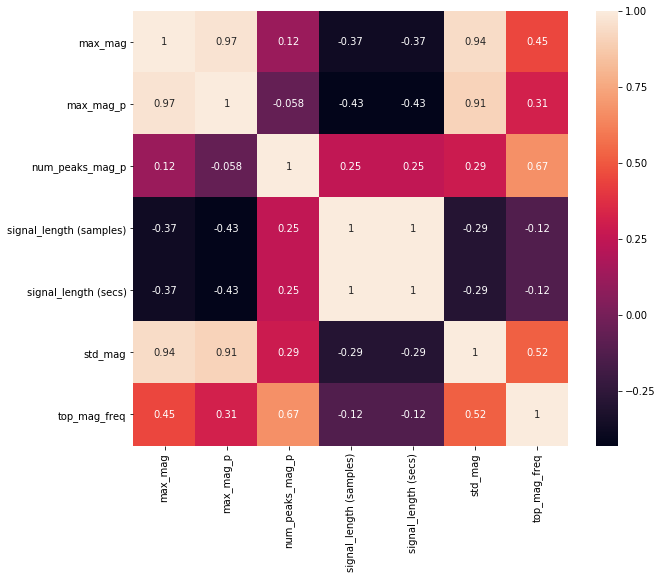

In [136]:
import seaborn as sns # Seaborn is just a prettier plotting library

plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True, annot=True);

We can also plot a "prettier" version of the correlation matrix (that also takes advantage of its symmetry by only showing one side).

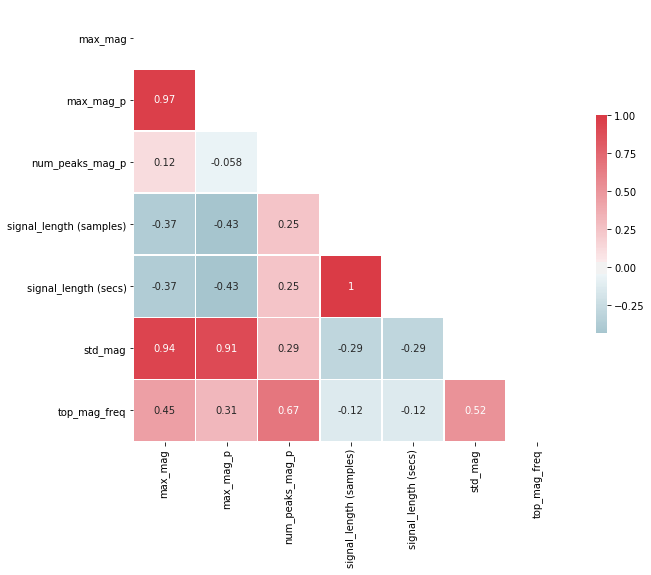

In [137]:
# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Given that the correlation table is symmetrical, we remove one side 

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

### Drop highly correlated features
We can use the results of the pairwise correlation to directly drop highly correlated features (see [link](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)).

In [138]:
# Create correlation matrix
# Take the abs value so both negative and positive correlations are mapped from 0 to 1
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

['max_mag_p', 'signal_length (secs)']


In [139]:
# Drop features 
print(f"Dropping {len(to_drop)} features: {to_drop}")
filtered_df = df.drop(columns=to_drop)
print()
print("Remaining features:")
display(filtered_df.sample(5))

Dropping 2 features: ['max_mag_p', 'signal_length (secs)']

Remaining features:


max_mag  num_peaks_mag_p  signal_length (samples)       std_mag  \
12  45232.962140                3                      188   7679.274478   
18  48690.100513                2                      208  11716.716824   
17  50841.920341                2                      201  11813.960010   
7   33481.413590                2                      148   5826.532634   
30  20442.183836                2                      187   4764.963361   

    top_mag_freq  
12      3.914894  
18      0.884615  
17      0.915423  
7       1.243243  
30      0.983957

### Pair plots

A slightly different version of the pairwise correlation grids is a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html), which graphs a pairwise scattplot between each variable in a cell and a univariate distribution along the diagonal. Pairplots  combine our 2-dimensional explorations from before along with a pairwise correlation grid into a clean but highly information-dense visualization.

By default, just like the correlation grids above, the upper-right and lower-left (as split along the diagonal) are symmetrical. The diagonal shows a histrogram plot of the distribution of data for that variable. 

For more information, see:
- [Visualizing Data with Pair Plots](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166), Towards Data Science, April 2018
- [Section 1.7.3](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch01.html#first-things-first-look-at-your-data) of the [Introduction to Machine Learning with Python book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/), Andreas C. Müller & Sarah Guido, Oct 2016

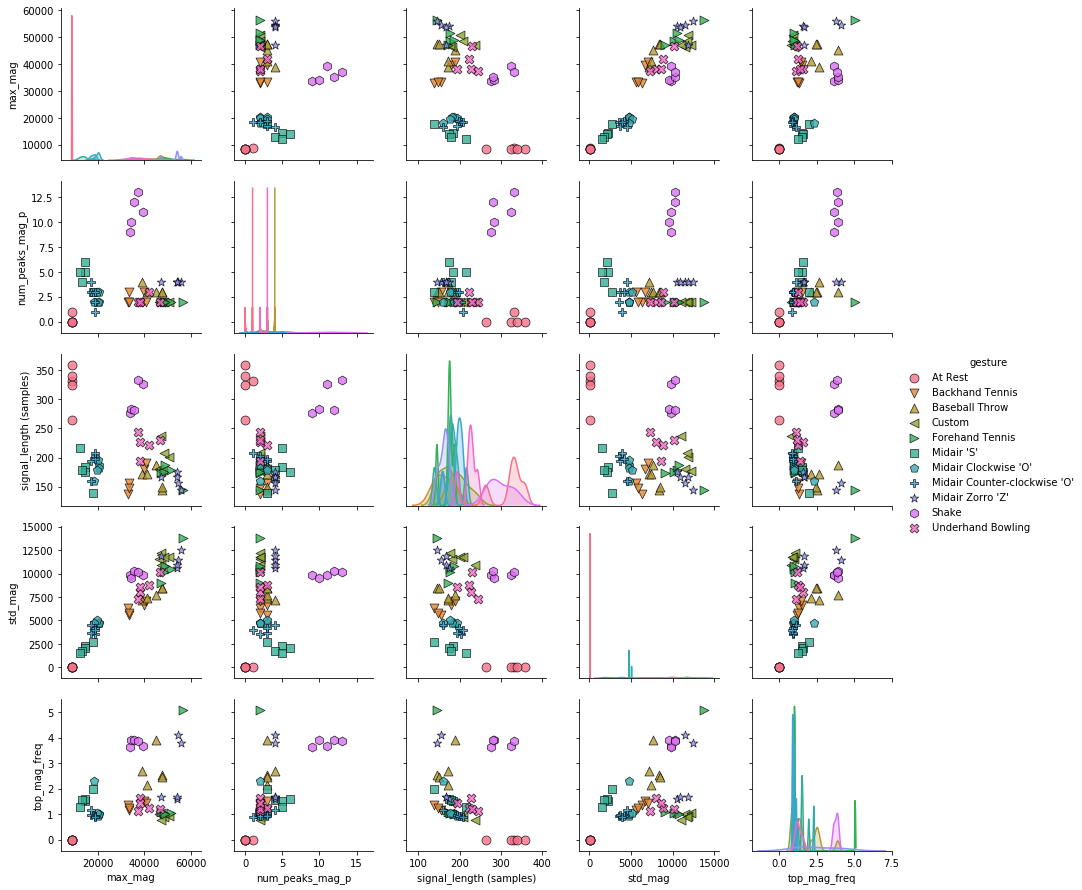

In [140]:
# Add the 'gesture' back into the DataFrame
filtered_df['gesture'] = gesture_col

# Create the pairplot (this might take a bit of time)
markers = plot_markers[:selected_gesture_set.get_num_gestures()]
sns.pairplot(filtered_df, hue="gesture", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);

### Box plots

Finally, pandas has a built-in function, called [`boxplot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html) to create a box-and-whisker plot from DataFrame columns. This enables you to explore the distribution of each feature and potential outliers.

If you're unfamiliar with these plots, "a box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to $1.5 * IQR (IQR = Q3 - Q1)$ from the edges of the box. Outlier points are those past the end of the whiskers" (from the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html))

For more information, see the Wikipedia entry on [box plots](https://en.wikipedia.org/wiki/Box_plot).

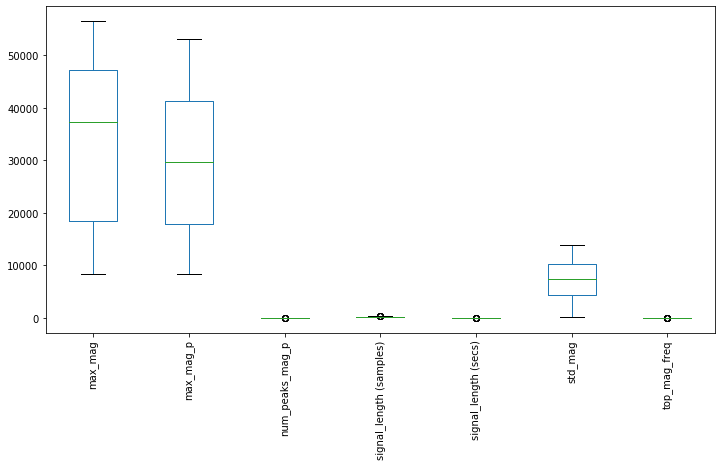

In [182]:
df.boxplot(grid=False, rot=90, fontsize=10, figsize=(12,6));

We can also graph boxplots grouped by a variable. In this case, let's group by 'gesture'.

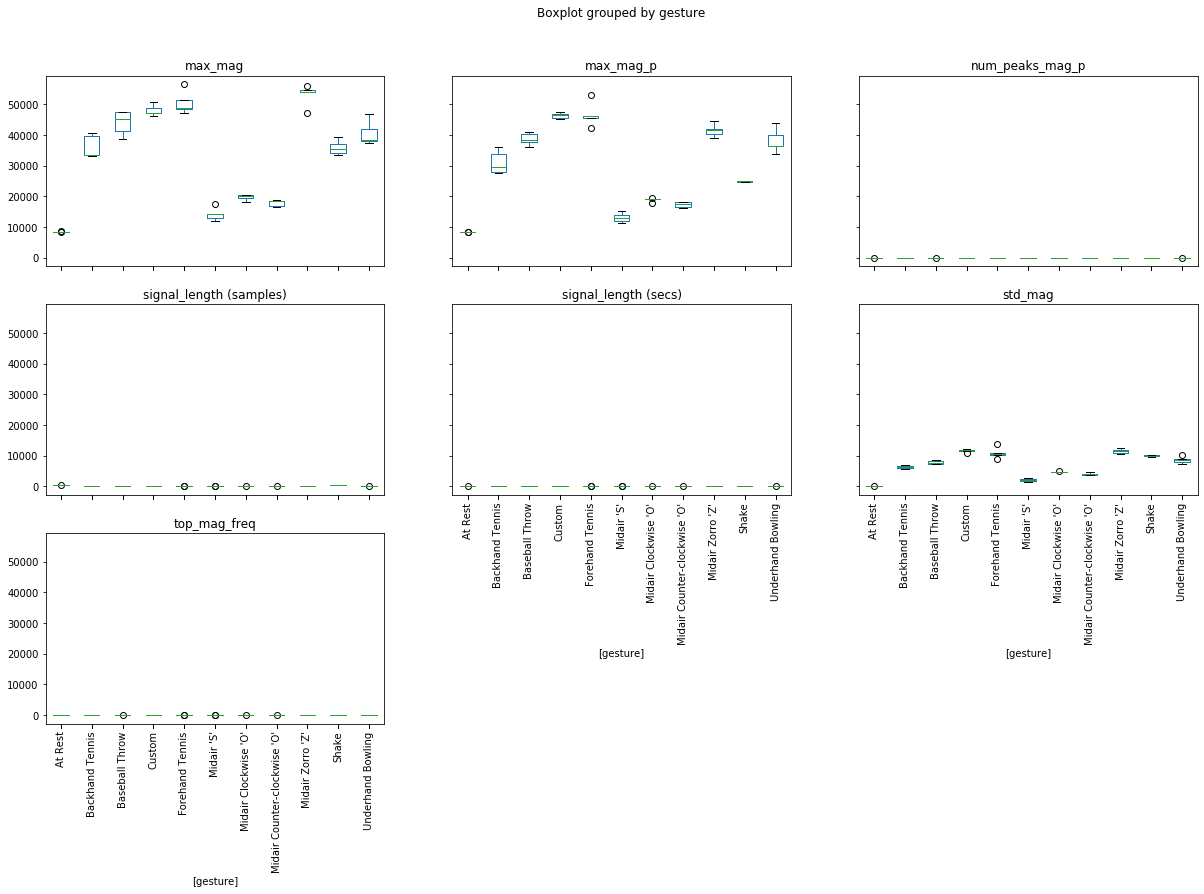

In [179]:
df['gesture'] = gesture_col
df.boxplot(by='gesture', grid=False, rot=90, fontsize=10, figsize=(20, 12));

# Classification 

Whew—and to think, we haven't even made it to classification yet!

But it's important to focus on selecting good features because even the most advanced classifiers won't work without good training examples.

Below, we will walk through an entire end-to-end classification example with Scikit-learn using a selected gesture set.

## Feature extraction code

Now that we've explored some features, you can add in some promising features to the method `extract_features_from_trial`, which our classifiers will use below.

This is where you spend quite a bit of time adding, subtracting, and manipulating input features for your model.

In [190]:
def extract_features_from_gesture_sets(gesture_sets, include_custom_gesture=True):
    '''
    Extracts features for all provided gesture sets.
    
    Parameters:
        gesture_sets: collection of GestureSet objects
        include_custom_gesture: if True, includes the custom gesture. Otherwise, not.
    '''
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set, include_custom_gesture)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

def extract_features_from_gesture_set(gesture_set, include_custom_gesture=True):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    
    gesture_names = None
    
    if include_custom_gesture:
        gesture_names = gesture_set.get_gesture_names_sorted()
    else:
        gesture_names = gesture_set.GESTURE_NAMES_WITHOUT_CUSTOM
    
    
    for gesture_name in gesture_names:
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # TODO: you may or may not want to keep these features
    # I just added them as examples! :)
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
    features.append(np.std(trial.accel.mag))
    feature_names.append("std(mag.max())")
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    features.append(extract_feature_num_peaks_mag_p(trial.accel))
    feature_names.append("num_peaks_mag_p")
    
    # TODO:
    # This is where you add in your new features to train the model
    
    return (features, feature_names)

## Building an initial classifier

Alright, let's build an initial feature-based, supervised learning classifier for our gesture data. For this example, we will use a [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html), a popular machine learning approach often used in gesture classification. (But other classification models are also possible, which we will show later. Thankfully, Scikit-learn is setup rather beautifully to enable us to swap in and out different classification models and parameters).

### Extract our features

First, let's run our feature extraction code and setup a Pandas DataFrame.

In [191]:
# Extract our features

# Set the selected gesture set. We'll start with my gesture set but you can loop around
# and play with your own
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

# Display the feature vector table and ground truth labels
print(f"Selected gesture set: {selected_gesture_set.name}")
display_tables_side_by_side(df, pd.DataFrame(y), n = 8, 
                            df1_caption = "Features", df2_caption = "Ground truth labels")

Selected gesture set: JonGestures


Features mag.max() std(mag.max()) signal_length top_mag_freq num_peaks_mag_p 
 
 0 
 8392.93 
 85.9805 
 407 
 0 
 1 
 
 
 1 
 8065.11 
 63.7863 
 702 
 0 
 0 
 
 
 2 
 8032.76 
 54.8318 
 529 
 0 
 0 
 
 
 3 
 8360.12 
 73.9136 
 889 
 0 
 0 
 
 
 4 
 8489.62 
 122.217 
 678 
 0 
 0 
 
 
 5 
 26276.7 
 3288.54 
 226 
 2.0354 
 2 
 
 
 6 
 38608.8 
 5753.68 
 246 
 2.2439 
 2 
 
 
 7 
 28739.7 
 4382.96 
 254 
 2.17323 
 2 
 
 Ground truth labels gesture 
 
 0 
 At Rest 
 
 
 1 
 At Rest 
 
 
 2 
 At Rest 
 
 
 3 
 At Rest 
 
 
 4 
 At Rest 
 
 
 5 
 Backhand Tennis 
 
 
 6 
 Backhand Tennis 
 
 
 7 
 Backhand Tennis

### Creating the classifier model

As previously noted, we will use an SVM for this example. As [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine) notes, "Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other". More specifically, an SVM constructs a "hyper-plane" that attempts to divide input features along a decision boundary. The samples along this decision boundary are called the "support vectors" since they are "supporting" the limits of the hyper-plane. 

<center>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png" width=500>
    <caption><smaller>This figure shows a binary classification with three samples on the decision boundary (the "support vectors")</smaller></caption>
</center>

For more information on SVMs, I recommend this approachable video by Alice Zhao entitled [Support Vector Machines: A Visual Explanation with Sample Python Code](https://youtu.be/N1vOgolbjSc).

I also suggest that you read through Scikit-learn's [Supervised Learning](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) tutorial.

So, let's do it!

In [31]:
from sklearn import svm

# Create a basic SVM with a linear kernel
# See: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Note: this simply instantiates the svm.SVC class and stores it in a var called clf
# it does not actually train and run the SVM (that comes later)
clf = svm.SVC(kernel='linear')

Yes, that's it. Rather anti-climatic, I know. Of course, there are many different types of SVM kernels (`linear`, `poly`) and also parameters to tune like a regularization factor called `C` and many other [things](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (not to mention other [classifiers](https://scikit-learn.org/stable/supervised_learning.html)). You'll likely want to experiment and read about these parameters.

For now, however, let's just focus on getting the full classification framework setup.

### Setting up the experiment

How should we evaluate our classifier's performance? In the shape-matching assignment, we used k-fold cross validation but there are other approaches. 

In setting up our experiment, we want to ensure:
- That we properly split our data into training and test sets. Often, an easy mistake to make (for novices and experts alike) is to accidentally include some test data into the training set. This will artifically inflate performance. Scikit-learn's experimental frameworks guard against this.
- That we don't necessarily run only a single experiment on one arbitrary split of the data. This may also give us a distorted view of performance.

The most straightforward is called 

#### 80/20 Split

The simplest experimental setup is to divide your data into a training and test set (*e.g.,* 50% for training, 50% for test). A common split is 80% for training and 20% for testing. This is a bit like our previous k-fold approach but only doing one fold (and thus, is not as rigorous).

Scikit-learn has a built-in function for this aptly called [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [32]:
from sklearn.model_selection import train_test_split

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

print("The training data:")
#display(X_train)
display_tables_side_by_side(X_train, pd.DataFrame(y_train), df1_caption="Input features", df2_caption="Class")

print("The test data:")
display_tables_side_by_side(X_test, pd.DataFrame(y_test), df1_caption="Input features", df2_caption="Class")

The training data:


Input features mag.max() std(mag.max()) signal_length top_mag_freq 
 
 45 
 41013.3 
 10792.6 
 481 
 13.9626 
 
 
 50 
 36611.5 
 6570.75 
 300 
 1.22667 
 
 
 3 
 8360.12 
 73.9136 
 889 
 0 
 
 
 47 
 34237.7 
 9136.19 
 283 
 16.5795 
 
 
 8 
 25896.5 
 3643.39 
 228 
 2.01754 
 
 
 23 
 45913.3 
 6887.55 
 334 
 4.40719 
 
 
 30 
 15885.2 
 3311.92 
 292 
 0.945205 
 
 
 39 
 22465.5 
 4418.85 
 202 
 1.36634 
 
 
 15 
 33770.5 
 9504.46 
 297 
 1.54882 
 
 
 34 
 21738.2 
 4558.13 
 251 
 1.0996 
 
 
 10 
 50026.1 
 8097.87 
 287 
 1.28223 
 
 
 44 
 46684.8 
 9712.69 
 212 
 3.4717 
 
 
 2 
 8032.76 
 54.8318 
 529 
 0 
 
 
 51 
 35859.2 
 6513.79 
 307 
 1.1987 
 
 
 37 
 17363.1 
 3469.13 
 235 
 1.17447 
 
 
 25 
 20797.5 
 3856.14 
 222 
 1.65766 
 
 
 33 
 19283.1 
 4475.74 
 223 
 1.23767 
 
 
 21 
 42595.1 
 7820.49 
 247 
 4.09717 
 
 
 32 
 24146.6 
 5013.2 
 228 
 1.21053 
 
 
 52 
 39258.6 
 7791.97 
 233 
 1.18455 
 
 
 42 
 43618.2 
 10698.3 
 220 
 2.09091 
 
 
 40 
 44109.5 
 9490.99 
 190 
 2.42105 
 
 
 20 
 40972.7 
 5989.5 
 387 
 2.37726 
 
 
 26 
 21263.2 
 4063.61 
 181 
 1.52486 
 
 
 48 
 34251.5 
 10059.3 
 471 
 4.29724 
 
 
 9 
 29550.2 
 4620.1 
 212 
 2.16981 
 
 
 24 
 38067.3 
 6255.51 
 206 
 4.01942 
 
 
 54 
 43738.1 
 8553.18 
 264 
 4.18182 
 
 
 0 
 8392.93 
 85.9805 
 407 
 0 
 
 
 18 
 35623.7 
 8983.28 
 358 
 1.5419 
 
 
 41 
 45972 
 8864.51 
 236 
 2.33898 
 
 
 7 
 28739.7 
 4382.96 
 254 
 2.17323 
 
 
 12 
 47391.8 
 8104.75 
 312 
 0.884615 
 
 
 46 
 40841.5 
 8259.7 
 520 
 10.7923 
 
 
 11 
 48729 
 7962.71 
 321 
 0.859813 
 
 
 27 
 22979.7 
 3857.94 
 273 
 1.68498 
 
 
 19 
 35468.5 
 7888.49 
 475 
 1.54947 
 
 
 38 
 19189.3 
 3871.85 
 212 
 1.30189 
 
 
 13 
 53762.5 
 8953.25 
 302 
 0.913907 
 
 
 28 
 21125 
 3584.54 
 218 
 0.844037 
 
 
 1 
 8065.11 
 63.7863 
 702 
 0 
 
 
 5 
 26276.7 
 3288.54 
 226 
 2.0354 
 
 
 36 
 19214.5 
 3627.78 
 217 
 1.27189 
 
 
 17 
 34396.8 
 7692.09 
 442 
 1.66516 
 
 Class gesture 
 
 45 
 Shake 
 
 
 50 
 Underhand Bowling 
 
 
 3 
 At Rest 
 
 
 47 
 Shake 
 
 
 8 
 Backhand Tennis 
 
 
 23 
 Forehand Tennis 
 
 
 30 
 Midair Clockwise 'O' 
 
 
 39 
 Midair Counter-clockwise 'O' 
 
 
 15 
 Custom 
 
 
 34 
 Midair Clockwise 'O' 
 
 
 10 
 Baseball Throw 
 
 
 44 
 Midair Zorro 'Z' 
 
 
 2 
 At Rest 
 
 
 51 
 Underhand Bowling 
 
 
 37 
 Midair Counter-clockwise 'O' 
 
 
 25 
 Midair 'S' 
 
 
 33 
 Midair Clockwise 'O' 
 
 
 21 
 Forehand Tennis 
 
 
 32 
 Midair Clockwise 'O' 
 
 
 52 
 Underhand Bowling 
 
 
 42 
 Midair Zorro 'Z' 
 
 
 40 
 Midair Zorro 'Z' 
 
 
 20 
 Forehand Tennis 
 
 
 26 
 Midair 'S' 
 
 
 48 
 Shake 
 
 
 9 
 Backhand Tennis 
 
 
 24 
 Forehand Tennis 
 
 
 54 
 Underhand Bowling 
 
 
 0 
 At Rest 
 
 
 18 
 Custom 
 
 
 41 
 Midair Zorro 'Z' 
 
 
 7 
 Backhand Tennis 
 
 
 12 
 Baseball Throw 
 
 
 46 
 Shake 
 
 
 11 
 Baseball Throw 
 
 
 27 
 Midair 'S' 
 
 
 19 
 Custom 
 
 
 38 
 Midair Counter-clockwise 'O' 
 
 
 13 
 Baseball Throw 
 
 
 28 
 Midair 'S' 
 
 
 1 
 At Rest 
 
 
 5 
 Backhand Tennis 
 
 
 36 
 Midair Counter-clockwise 'O' 
 
 
 17 
 Custom

The test data:


Input features mag.max() std(mag.max()) signal_length top_mag_freq 
 
 22 
 49911.1 
 6773.47 
 364 
 3.28571 
 
 
 53 
 47488 
 9275.36 
 265 
 0 
 
 
 4 
 8489.62 
 122.217 
 678 
 0 
 
 
 14 
 50808.4 
 8146.02 
 328 
 1.40244 
 
 
 29 
 18934.5 
 3197.56 
 248 
 2.22581 
 
 
 49 
 37256 
 7548.85 
 425 
 7.79294 
 
 
 6 
 38608.8 
 5753.68 
 246 
 2.2439 
 
 
 16 
 35672.8 
 8296.31 
 433 
 1.69977 
 
 
 43 
 42048.3 
 9735.17 
 189 
 3.40741 
 
 
 35 
 17664.8 
 3440.6 
 224 
 1.23214 
 
 
 31 
 20497.9 
 3993.06 
 286 
 0.965035 
 
 Class gesture 
 
 22 
 Forehand Tennis 
 
 
 53 
 Underhand Bowling 
 
 
 4 
 At Rest 
 
 
 14 
 Baseball Throw 
 
 
 29 
 Midair 'S' 
 
 
 49 
 Shake 
 
 
 6 
 Backhand Tennis 
 
 
 16 
 Custom 
 
 
 43 
 Midair Zorro 'Z' 
 
 
 35 
 Midair Counter-clockwise 'O' 
 
 
 31 
 Midair Clockwise 'O'

#### Basic k-fold cross validation

In the [shape-matching assignment](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html), you implemented your own k-fold cross validation algorithm. While we didn't emphasize this then, your k-fold implementation was a type of **stratified** k-fold in that your folds guarantteed one sample of each class in each fold.

A more general k-fold implementation is class agnostic: it will split up your data randomly into five folds with no guarantees about class representation.

We can use [`sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) for this, which takes in:
- **n_splits**: Number of folds. Must be at least 2. Defaults to 5.
- **shuffle**: Whether to shuffle the data before splitting into folds.
- **random_state**: Controls how to shuffle the data. If you want to repeat the same random shuffling, pass in an **int** to be used as the random seed.

Let's take a look.

In [33]:
from sklearn.model_selection import KFold

kf_cross_validator = KFold(n_splits=5, shuffle=True)
display_folds(kf_cross_validator, X, y, trial_indices)

Fold 0                          Fold 1  \
0                        At Rest 2                        Custom 0   
1                        At Rest 3                        Custom 2   
2                Backhand Tennis 0                        Custom 3   
3                Backhand Tennis 2                        Custom 4   
4                 Baseball Throw 1               Forehand Tennis 0   
5                Forehand Tennis 2          Midair Clockwise 'O' 2   
6                Forehand Tennis 3  Midair Counter-clockwise 'O' 2   
7   Midair Counter-clockwise 'O' 1              Midair Zorro 'Z' 0   
8                          Shake 0              Midair Zorro 'Z' 3   
9                          Shake 1                         Shake 2   
10             Underhand Bowling 0             Underhand Bowling 1   

                            Fold 2                          Fold 3  \
0                        At Rest 4                       At Rest 1   
1                Backhand Tennis 3               Backhand Tennis 1   
2                 Baseball Throw 3               Forehand Tennis 4   
3                     Midair 'S' 0                    Midair 'S' 1   
4                     Midair 'S' 3                    Midair 'S' 4   
5           Midair Clockwise 'O' 4          Midair Clockwise 'O' 3   
6   Midair Counter-clockwise 'O' 3  Midair Counter-clockwise 'O' 4   
7                          Shake 3              Midair Zorro 'Z' 1   
8              Underhand Bowling 2              Midair Zorro 'Z' 2   
9              Underhand Bowling 3              Midair Zorro 'Z' 4   
10             Underhand Bowling 4                         Shake 4   

                            Fold 4  
0                        At Rest 0  
1                Backhand Tennis 4  
2                 Baseball Throw 0  
3                 Baseball Throw 2  
4                 Baseball Throw 4  
5                         Custom 1  
6                Forehand Tennis 1  
7                     Midair 'S' 2  
8           Midair Clockwise 'O' 0  
9           Midair Clockwise 'O' 1  
10  Midair Counter-clockwise 'O' 0

But the problem with a basic k-fold cross validation, at least for our purposes, is that we want to ensure that the "correct answer" is *always* in a test fold (and this is relatively easy to accomplish because we have a perfectly balanced dataset of five samples per class). The basic KFold model doesn't do this.

So, what do we do? Enter: stratified k-fold cross validation. This is very similar to what you implemented in your last assignment.

#### Stratified k-fold cross validation

A [stratified k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) creates folds that preserve the percentange of samples for each class (and again, we have a perfectly balanced dataset, so 20% of each class—or one sample—will go in each fold.)

Fortunately, and quite elegantly, the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) API is the same as for regular [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): `sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)`.

Let's try it out.

If things work the way they should, then we will have one sample of each class in each fold. Take a careful look at the output table.

In [34]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

Fold 0                          Fold 1  \
0                        At Rest 3                       At Rest 0   
1                Backhand Tennis 0               Backhand Tennis 2   
2                 Baseball Throw 4                Baseball Throw 1   
3                         Custom 3                        Custom 1   
4                Forehand Tennis 1               Forehand Tennis 4   
5                     Midair 'S' 3                    Midair 'S' 4   
6           Midair Clockwise 'O' 2          Midair Clockwise 'O' 4   
7   Midair Counter-clockwise 'O' 4  Midair Counter-clockwise 'O' 0   
8               Midair Zorro 'Z' 1              Midair Zorro 'Z' 3   
9                          Shake 2                         Shake 3   
10             Underhand Bowling 0             Underhand Bowling 3   

                            Fold 2                          Fold 3  \
0                        At Rest 1                       At Rest 4   
1                Backhand Tennis 1               Backhand Tennis 4   
2                 Baseball Throw 3                Baseball Throw 2   
3                         Custom 4                        Custom 0   
4                Forehand Tennis 2               Forehand Tennis 3   
5                     Midair 'S' 0                    Midair 'S' 1   
6           Midair Clockwise 'O' 3          Midair Clockwise 'O' 1   
7   Midair Counter-clockwise 'O' 1  Midair Counter-clockwise 'O' 3   
8               Midair Zorro 'Z' 2              Midair Zorro 'Z' 4   
9                          Shake 4                         Shake 0   
10             Underhand Bowling 2             Underhand Bowling 1   

                            Fold 4  
0                        At Rest 2  
1                Backhand Tennis 3  
2                 Baseball Throw 0  
3                         Custom 2  
4                Forehand Tennis 0  
5                     Midair 'S' 2  
6           Midair Clockwise 'O' 0  
7   Midair Counter-clockwise 'O' 2  
8               Midair Zorro 'Z' 0  
9                          Shake 1  
10             Underhand Bowling 4

It worked!

#### Playing with shuffle and random state

It's often best to shuffle our folds randomly to setup our validation experiment; however, to control for reproducibility—for example, to use the same split across multiple executions (say, if you changed a preprocessing algorithm and wanted to evaluate its impact)—Scikit-learn allows you to manipulate how the random split occurs. Most simply, by passing in an `int`, which will be used as the random seed for the split. The same `int` will always produce the same split.

Let's check it out!

In [35]:
# Rerun this cell and you'll get new random splits every time
skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

Fold 0                          Fold 1  \
0                        At Rest 4                       At Rest 2   
1                Backhand Tennis 2               Backhand Tennis 1   
2                 Baseball Throw 1                Baseball Throw 3   
3                         Custom 4                        Custom 2   
4                Forehand Tennis 3               Forehand Tennis 4   
5                     Midair 'S' 4                    Midair 'S' 1   
6           Midair Clockwise 'O' 4          Midair Clockwise 'O' 3   
7   Midair Counter-clockwise 'O' 0  Midair Counter-clockwise 'O' 2   
8               Midair Zorro 'Z' 0              Midair Zorro 'Z' 3   
9                          Shake 1                         Shake 3   
10             Underhand Bowling 0             Underhand Bowling 2   

                            Fold 2                          Fold 3  \
0                        At Rest 1                       At Rest 3   
1                Backhand Tennis 4               Backhand Tennis 3   
2                 Baseball Throw 4                Baseball Throw 2   
3                         Custom 3                        Custom 1   
4                Forehand Tennis 1               Forehand Tennis 2   
5                     Midair 'S' 0                    Midair 'S' 3   
6           Midair Clockwise 'O' 2          Midair Clockwise 'O' 1   
7   Midair Counter-clockwise 'O' 1  Midair Counter-clockwise 'O' 4   
8               Midair Zorro 'Z' 2              Midair Zorro 'Z' 1   
9                          Shake 4                         Shake 0   
10             Underhand Bowling 1             Underhand Bowling 3   

                            Fold 4  
0                        At Rest 0  
1                Backhand Tennis 0  
2                 Baseball Throw 0  
3                         Custom 0  
4                Forehand Tennis 0  
5                     Midair 'S' 2  
6           Midair Clockwise 'O' 0  
7   Midair Counter-clockwise 'O' 3  
8               Midair Zorro 'Z' 4  
9                          Shake 2  
10             Underhand Bowling 4

In [36]:
# Rerun this cell and you'll get the same splits every time
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)
display_folds(skf, X, y, trial_indices)

Fold 0                          Fold 1  \
0                        At Rest 3                       At Rest 4   
1                Backhand Tennis 2               Backhand Tennis 1   
2                 Baseball Throw 0                Baseball Throw 4   
3                         Custom 3                        Custom 0   
4                Forehand Tennis 3               Forehand Tennis 2   
5                     Midair 'S' 3                    Midair 'S' 4   
6           Midair Clockwise 'O' 3          Midair Clockwise 'O' 1   
7   Midair Counter-clockwise 'O' 4  Midair Counter-clockwise 'O' 0   
8               Midair Zorro 'Z' 3              Midair Zorro 'Z' 0   
9                          Shake 4                         Shake 1   
10             Underhand Bowling 2             Underhand Bowling 4   

                            Fold 2                          Fold 3  \
0                        At Rest 1                       At Rest 0   
1                Backhand Tennis 3               Backhand Tennis 4   
2                 Baseball Throw 1                Baseball Throw 2   
3                         Custom 4                        Custom 1   
4                Forehand Tennis 1               Forehand Tennis 0   
5                     Midair 'S' 1                    Midair 'S' 2   
6           Midair Clockwise 'O' 0          Midair Clockwise 'O' 4   
7   Midair Counter-clockwise 'O' 1  Midair Counter-clockwise 'O' 2   
8               Midair Zorro 'Z' 2              Midair Zorro 'Z' 4   
9                          Shake 0                         Shake 2   
10             Underhand Bowling 0             Underhand Bowling 3   

                            Fold 4  
0                        At Rest 2  
1                Backhand Tennis 0  
2                 Baseball Throw 3  
3                         Custom 2  
4                Forehand Tennis 4  
5                     Midair 'S' 0  
6           Midair Clockwise 'O' 2  
7   Midair Counter-clockwise 'O' 3  
8               Midair Zorro 'Z' 1  
9                          Shake 3  
10             Underhand Bowling 1

### Running the experiment

Finally, we are ready to run our classification experiment using cross-validation.

#### Using cross_val_score

Let's start with the simplest way to this, using [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), which takes in (among other things):
- **estimator**: A classifier, which Scikit-learn calls more generally an estimator (because their framework works with regression problems as well as classification problems). Recall that we instantiated an SVM model and stored it in the `clf` variable (the SVM has yet to be trained, that's what this step does).
- **X**: our input features
- **y**: the class labels
- **cv**: the cross validation model, which we previously created as a `StratifiedKFold` and stored it in `skf`

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=skf)
print("Fold scores:", scores)
print("Overall: {:.2f}%".format(np.mean(scores) * 100))

Fold scores: [0.63636364 0.63636364 0.63636364 0.72727273 0.63636364]
Overall: 65.45%


Not bad, huh? 65.5% accuracy with just a few simple features. And you'll be able to do much better once you add in more thoughtful features.

#### Using cross_validate

Let's use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function instead of `cross_val_score` to produce more detailed performance results like how long each training and testing step took (called `fit_time` and `score_time`, respectively). 

Noticeably, the SVM is much faster to train and test than our shape-based models from before!

In [38]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(clf, X, y, cv=skf, return_train_score=False)
print(cv_results)

{'fit_time': array([0.01699805, 0.04799581, 0.12299776, 0.02500153, 0.01199532]), 'score_time': array([0.00099945, 0.00200295, 0.0010004 , 0.00200176, 0.00100088]), 'test_score': array([0.63636364, 0.63636364, 0.63636364, 0.72727273, 0.63636364])}


Beautify into a Pandas DataFrame table.

In [39]:
display(pd.DataFrame(cv_results))
print(f"Overall average: {np.mean(cv_results['test_score']):.3f} (SD={np.std(cv_results['test_score']):0.3f})")

fit_time  score_time  test_score
0  0.016998    0.000999    0.636364
1  0.047996    0.002003    0.636364
2  0.122998    0.001000    0.636364
3  0.025002    0.002002    0.727273
4  0.011995    0.001001    0.636364

Overall average: 0.655 (SD=0.036)


#### Using cross_val_predict

Perhaps the most useful experimental validation method, however, is [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html), which returns a prediction array that we can use to compute additional performance statistics.

In [40]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, X, y, cv=skf)
print(y_pred)

['At Rest' 'At Rest' 'At Rest' 'At Rest' 'At Rest' 'Backhand Tennis'
 'Forehand Tennis' 'Backhand Tennis' 'Backhand Tennis' 'Backhand Tennis'
 'Baseball Throw' 'Baseball Throw' 'Baseball Throw' 'Baseball Throw'
 'Baseball Throw' 'Custom' 'Custom' 'Custom' 'Shake' 'Custom'
 'Backhand Tennis' 'Underhand Bowling' 'Baseball Throw' 'Forehand Tennis'
 'Backhand Tennis' "Midair 'S'" "Midair Counter-clockwise 'O'"
 "Midair 'S'" "Midair 'S'" "Midair 'S'" "Midair Clockwise 'O'"
 "Midair Counter-clockwise 'O'" "Midair 'S'" "Midair Clockwise 'O'"
 "Midair Clockwise 'O'" "Midair Counter-clockwise 'O'" "Midair 'S'"
 "Midair Counter-clockwise 'O'" "Midair Counter-clockwise 'O'"
 "Midair 'S'" "Midair Zorro 'Z'" 'Underhand Bowling' "Midair Zorro 'Z'"
 'Shake' "Midair Zorro 'Z'" "Midair Zorro 'Z'" 'Underhand Bowling'
 'Custom' 'Custom' 'Shake' 'Underhand Bowling' 'Underhand Bowling' 'Shake'
 "Midair Zorro 'Z'" 'Underhand Bowling']


With the `y_pred` array, you can now use other metrics like accuracy_score, confusion matrix, *etc.*

In [41]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y, y_pred)
print(f"{overall_acc * 100:0.2f}%")

65.45%


#### Classification report

With the `y_pred` array, we can build a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.67      0.80      0.73         5
              Baseball Throw       0.83      1.00      0.91         5
                      Custom       0.67      0.80      0.73         5
             Forehand Tennis       0.50      0.20      0.29         5
                  Midair 'S'       0.57      0.80      0.67         5
        Midair Clockwise 'O'       1.00      0.60      0.75         5
Midair Counter-clockwise 'O'       0.60      0.60      0.60         5
            Midair Zorro 'Z'       0.60      0.60      0.60         5
                       Shake       0.25      0.20      0.22         5
           Underhand Bowling       0.50      0.60      0.55         5

                    accuracy                           0.65        55
                   macro avg       0.65      0.65      0.64        55
                we

#### Build a confusion matrix

Now let's build our friendly, helpful confusion matrices!

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
print(cm)

[[5 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 1 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 1 0]
 [0 2 1 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 1 3 1 0 0 0]
 [0 0 0 0 0 2 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 3 1 1]
 [0 0 0 2 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 3]]


Beautify the confusion matrix:

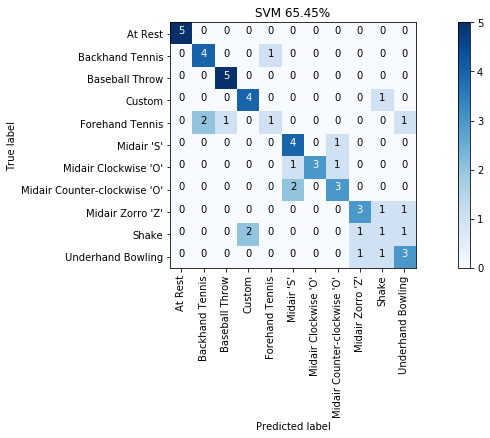

In [44]:
import sklearn.metrics

cm_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=cm_title)

## Scaling our input features

A final but no less important step—which we skipped over above simply to provide a straightforward example—is that many classifiers (including an SVM) are sensitive to feature scaling. That is, performance varies dramatically if all input features are not normalized.

Fortunately, Scikit-learn has a solution but it does introduce a bit of complexity: namely, we shift from using our core classifier model `clf` to a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object, which takes in a list of "steps" and executes them sequentially where steps can include preprocessing, transforming, and eventually classifying an input.

Importantly, Scikit-learn "learns" a feature-scaling model for each feature from the *training* set and applies it to the test set. 

If you're curious about preprocessing data, in general, for machine learning, we suggest Scikit-learn's article on [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) and the Wikipedia article on [Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling). This [Towards Data Science article](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) also has a good discussion of different Scikit-learn scaling features, including [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### Using StandardScaler

We'll show how to use one normalization method with Scikit-learn: [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which standardizes features by removing the mean and scaling to unit variance.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform. Again, importantly, we "learn" scalings based on our training set only, which we then apply to our test set (and yes, we run the risk of unexpected transforms if our test set data does not look like our training set data).

#### Graphing features before and after StandardScaler

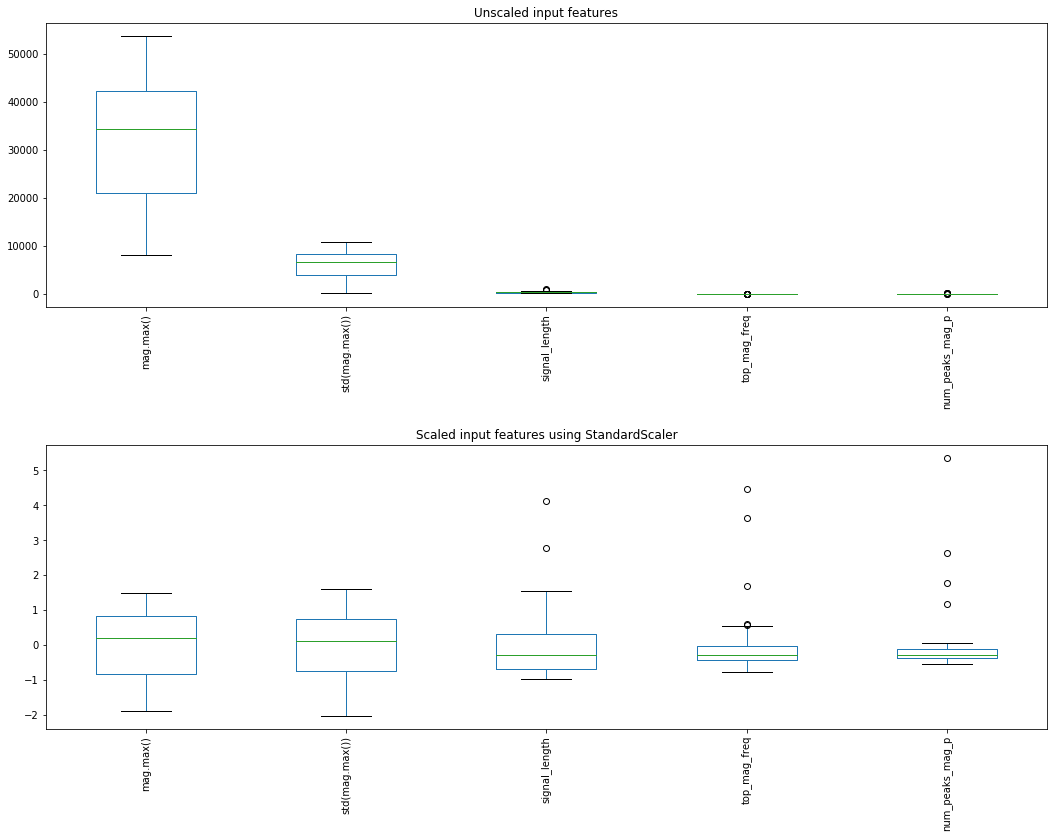

In [199]:
from sklearn.preprocessing import StandardScaler

# For this example, we'll use 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

# Create the transform class
scaler = StandardScaler()
scaler.fit(X_train) # "learn" a scaling model from the training data for each feature
X_train_scaled = scaler.transform(X_train) # actually apply the scaling

# Plot the unscaled and scaled versions
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
# display(X.head())
# display(df_train_scaled.head())

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
df.boxplot(grid=False, rot=90, fontsize=10, ax=axes[0]);
df_train_scaled.boxplot(grid=False, rot=90, fontsize=10, ax=axes[1])
axes[0].set_title("Unscaled input features")
axes[1].set_title("Scaled input features using StandardScaler")
fig.tight_layout(pad = 2)

#### Incorporating StandardScaler into our classification pipeline

To use StandardScaler or any of the [preprocessing steps](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) with Scikit-learn, it's best to use a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object. Pipelines are a sequence of "steps" that the Scikit-learn framework will execute in order.

Let's try it.

SCALED RESULTS: 70.91%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.50      0.20      0.29         5
              Baseball Throw       0.83      1.00      0.91         5
                      Custom       1.00      0.80      0.89         5
             Forehand Tennis       0.60      0.60      0.60         5
                  Midair 'S'       0.25      0.40      0.31         5
        Midair Clockwise 'O'       0.67      0.40      0.50         5
Midair Counter-clockwise 'O'       0.57      0.80      0.67         5
            Midair Zorro 'Z'       1.00      1.00      1.00         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       0.60      0.60      0.60         5

                    accuracy                           0.71        55
                   macro avg       0.73      0.71      0.71      

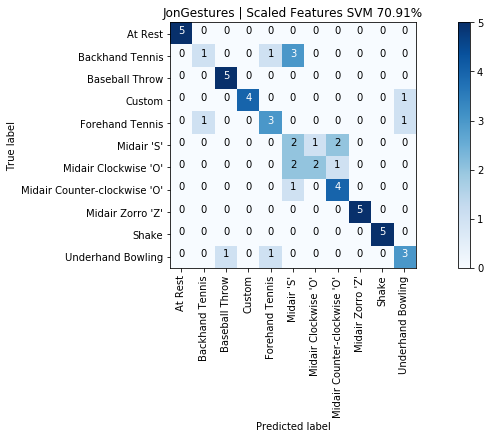

In [213]:
from sklearn.pipeline import Pipeline

# Create the transform class
scaler = StandardScaler()

# Create the pipeline object. Scikit-learn will execute these objects in sequence
# and use the output from one to the other
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

# Now use cross_val_predict with our pipeline object vs. clf
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | Scaled Features SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

As expected with an SVM model, our results improved!

### MinMaxScaler

As a point of comparison and to show you what's possible, let's try another scaling transform called [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which transforms features in a given range using:

```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

where `min` and `max` are the `min` and `max` of the input variable `feature_range` (which defaults to 0 and 1).

#### Graphing before and after with MinMaxScaler

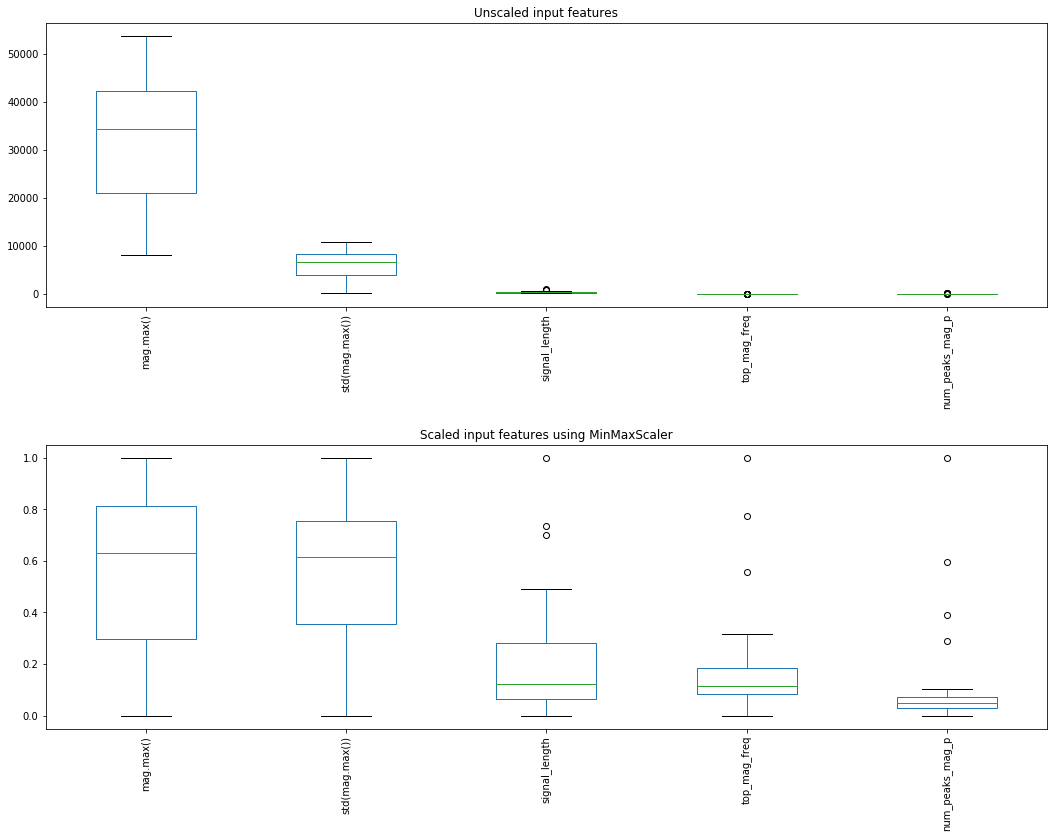

In [201]:
from sklearn.preprocessing import MinMaxScaler

# For this example, we'll use 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

# Create the transform class
scaler = MinMaxScaler()
scaler.fit(X_train) # "learn" a scaling model from the training data for each feature
X_train_scaled = scaler.transform(X_train) # actually apply the scaling

# Plot the unscaled and scaled versions
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
df.boxplot(grid=False, rot=90, fontsize=10, ax=axes[0]);
df_train_scaled.boxplot(grid=False, rot=90, fontsize=10, ax=axes[1])
axes[0].set_title("Unscaled input features")
axes[1].set_title("Scaled input features using MinMaxScaler")
fig.tight_layout(pad = 2)

#### Classification with MinMaxScaler
As before, let's run a full classification using MinMaxScaler in a pipeline object.

SCALED RESULTS: 63.64%
                              precision    recall  f1-score   support

                     At Rest       1.00      0.80      0.89         5
             Backhand Tennis       1.00      0.40      0.57         5
              Baseball Throw       0.83      1.00      0.91         5
                      Custom       0.62      1.00      0.77         5
             Forehand Tennis       0.60      0.60      0.60         5
                  Midair 'S'       0.20      0.20      0.20         5
        Midair Clockwise 'O'       0.50      0.40      0.44         5
Midair Counter-clockwise 'O'       0.44      0.80      0.57         5
            Midair Zorro 'Z'       0.71      1.00      0.83         5
                       Shake       1.00      0.60      0.75         5
           Underhand Bowling       0.50      0.20      0.29         5

                    accuracy                           0.64        55
                   macro avg       0.67      0.64      0.62      

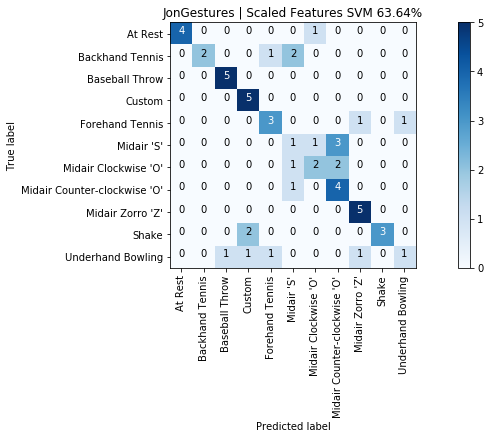

In [212]:
# Create the transform class
scaler = MinMaxScaler()

# Create the pipeline object. Scikit-learn will execute these objects in sequence
# and use the output from one to the other
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

# Now use cross_val_predict with our pipeline object vs. clf
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | Scaled Features SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Full SVM example (redux)

OK, let's do that again but this time in a single cell (so it's easier to see how everything fits together). And let's pick a different gesture set this time as well.

In [46]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is currently: {selected_gesture_set.name}")

We have 27 gesture sets:
 AGestures with 55 trials
 AlexandraGestures with 55 trials
 AlexisGestures with 55 trials
 AnjaliGestures with 55 trials
 BrettGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 DustinGestures with 55 trials
 EmmaGestures with 55 trials
 JaeHGestures with 55 trials
 JasonGestures with 55 trials
 JonGestures with 55 trials
 JuliaBGestures with 55 trials
 JustinGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 NanGestures with 55 trials
 NeilGestures with 55 trials
 NickGestures with 55 trials
 NooseGestures with 55 trials
 OjasviGestures with 55 trials
 Paf2Gestures with 55 trials
 SamuelRGestures with 55 trials
 ShaunGestures with 55 trials
 StacyGestures with 55 trials
 ThweidGestures with 55 trials
 WolfGestures with 55 trials
The selected gesture set is currently: JonGestures


Results for JonGestures
Overall SVM accuracy: 70.91%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.50      0.20      0.29         5
              Baseball Throw       0.83      1.00      0.91         5
                      Custom       1.00      0.80      0.89         5
             Forehand Tennis       0.60      0.60      0.60         5
                  Midair 'S'       0.25      0.40      0.31         5
        Midair Clockwise 'O'       0.67      0.40      0.50         5
Midair Counter-clockwise 'O'       0.57      0.80      0.67         5
            Midair Zorro 'Z'       1.00      1.00      1.00         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       0.60      0.60      0.60         5

                    accuracy                           0.71        55
                   macro avg       

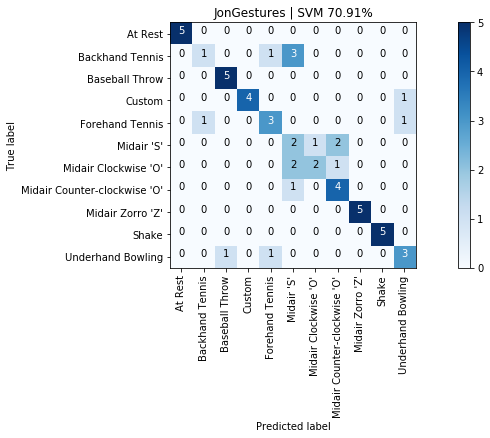

In [206]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=0.4)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Experimenting with other classifiers

By now, hopefully, you've realized the breadth and depth of the Scikit-learn library—and again, we've only touched on a small number of possibilities. Before we complete this introduction, we wanted to emphasize one other architectural delight: the various Scikit-learn classifiers have the same basic API and so can be easily swapped and compared with one another (indeed, you can even design and implement your own classifier class if you'd like).

We'll just quickly show two other common classifiers: [k-nearest neighbors (kNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and a [decision tree](https://scikit-learn.org/stable/modules/tree.html).

### kNN classifier
For background on nearest neighbor approaches, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/neighbors.html).

Results for JustinGestures
Overall kNN accuracy: 81.82%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.83      1.00      0.91         5
              Baseball Throw       0.71      1.00      0.83         5
                      Custom       0.67      0.80      0.73         5
             Forehand Tennis       0.67      0.80      0.73         5
                  Midair 'S'       0.83      1.00      0.91         5
        Midair Clockwise 'O'       0.80      0.80      0.80         5
Midair Counter-clockwise 'O'       1.00      0.80      0.89         5
            Midair Zorro 'Z'       0.50      0.20      0.29         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       1.00      0.60      0.75         5

                    accuracy                           0.82        55
                   macro avg    

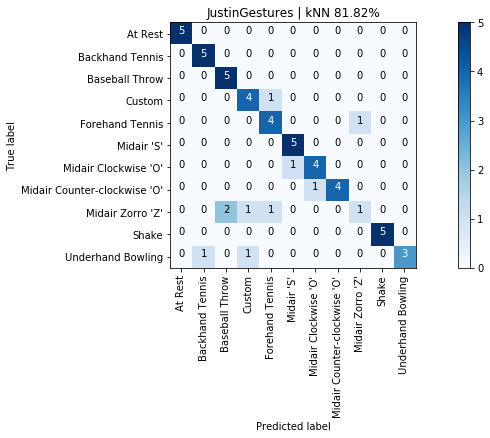

In [48]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

### Decision tree classifier
For background on decision trees, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/tree.html).

Results for JustinGestures
Overall kNN accuracy: 78.18%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.80      0.80      0.80         5
              Baseball Throw       0.83      1.00      0.91         5
                      Custom       0.60      0.60      0.60         5
             Forehand Tennis       0.40      0.40      0.40         5
                  Midair 'S'       1.00      1.00      1.00         5
        Midair Clockwise 'O'       1.00      0.80      0.89         5
Midair Counter-clockwise 'O'       0.83      1.00      0.91         5
            Midair Zorro 'Z'       0.60      0.60      0.60         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       0.50      0.40      0.44         5

                    accuracy                           0.78        55
                   macro avg    

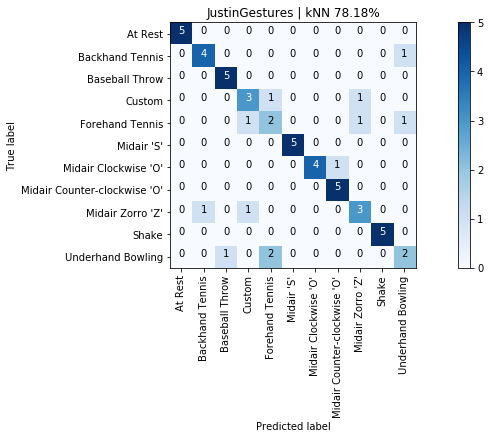

In [49]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

# Cross-user classification

For your assignment, we would like you to build two cross-user models:
- The **first model** is trained on all users (the training set) except for one (the test set). Iterate through all users as test sets and report classification accuracies for each (in graph form) as well as overall accuracies (average accuracy across all users with standard deviation). To be clear, you are not running a standard k-fold cross validation here but instead a leave-one-out validation approach (where you leave one user out from the training set per classification experiment).

- For the **second cross-user model**, train again on *all* users but also four of the five gesture samples (of each gesture) from the target user. To simplify things, you need not run k-fold cross validation. You can simply randomly select four of five gesture samples (once). We expect that classification accuracies should increase here. Is that what happens? **Update:** The example code that we provide below does run k-fold cross validation, so please just use that. 

Importantly, we need to **exclude** the custom gesture since everyone's gesture for this is different.

Put your code and performance results below here.

## First model: Leave one group out

We are going to help you setup an initial experimental framework—first by hand to build intuition and then using Scikit-learn's [LeaveOneGroupOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) method.

By providing this scaffolding, we hope you can focus on feature selection, selecting a model, and parameter tuning.

### Manual implementation
Below, we show how to manually build a leave-one-group-out cross validation. The overall idea is to use `N - 1` gesture sets as training and the `Nth` gesture set as a test set. Then iterate through all combinations so each gesture set serves as a leave-one-out test set.

In [50]:
# Extract all features across *all* gesture sets. We'll manage which is used for training and test below
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values(),
                                                                              include_custom_gesture=False)
# Convert into a lovely Pandas DataFrame
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # we don't want trial_num as an input feature
scores = [] # store our overall accuracy scores

map_gesture_set_name_to_score = dict()
# Here's where we iterate through all gesture sets, keeping one as a test and the rest as training
# for each iteration
for test_gesture_set in map_gesture_sets.values():
    
    # get all gesture sets except for the test set
    training_gesture_sets = grdata.get_all_gesture_sets_except(map_gesture_sets, test_gesture_set.name)
    
    # setup the test and training set DataFrames
    test_set_df = df.loc[df['gesturer'] == test_gesture_set.name]
    training_set_df = df.drop(list(test_set_df.index.values))
    
    # debug prints
    #print(f"The test set contains {len(test_set_df)} rows and {test_set_df['gesturer'].nunique()} gesturers")
    #print(f"The training set contains {len(training_set_df)} rows and {training_set_df['gesturer'].nunique()} gesturers")
          
    # we don't want 'gesturer' as an input feature, so remove it
    test_set_df.pop('gesturer')
    training_set_df.pop('gesturer')

    # Setup our training and test sets (and use variable names consistent with the Scikit-learn world)
    X_train = training_set_df
    y_train = training_set_df.pop('gesture')
    X_test = test_set_df
    y_test = test_set_df.pop('gesture')
    
    # debug prints
    #print(f"The test set has {len(X_test.columns)} input features")
    #print(f"The test set's input features: {X_test.columns.values}")
     
    # Scale data. Super critical. Try commenting this out and observing what happens!
    scaler = StandardScaler()
    scaler.fit(X_train) # learn scaling from training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Create our classifier. Change this to whatever you want
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    
    score = clf.score(X_test, y_test)
    # y_pred = clf.predict(X_test) # to get more detailed perf, you can do clf.predict
    scores.append(score)
    print(f"{test_gesture_set.name}: {score * 100:.2f}%")
    map_gesture_set_name_to_score[test_gesture_set.name] = score

print("--------")
print(f"Overall accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)")

AGestures: 28.00%
AlexandraGestures: 40.00%
AlexisGestures: 42.00%
AnjaliGestures: 56.00%
BrettGestures: 50.00%
BryanGestures: 30.00%
ClayGestures: 36.00%
DustinGestures: 46.00%
EmmaGestures: 32.00%
JaeHGestures: 48.00%
JasonGestures: 50.00%
JonGestures: 52.00%
JuliaBGestures: 36.00%
JustinGestures: 56.00%
MattCGestures: 36.00%
MikaelGestures: 46.00%
NanGestures: 46.00%
NeilGestures: 36.00%
NickGestures: 46.00%
NooseGestures: 32.00%
OjasviGestures: 46.00%
Paf2Gestures: 44.00%
SamuelRGestures: 42.00%
ShaunGestures: 34.00%
StacyGestures: 28.00%
ThweidGestures: 56.00%
WolfGestures: 44.00%
--------
Overall accuracy: 42.15% (SD=8.36%)


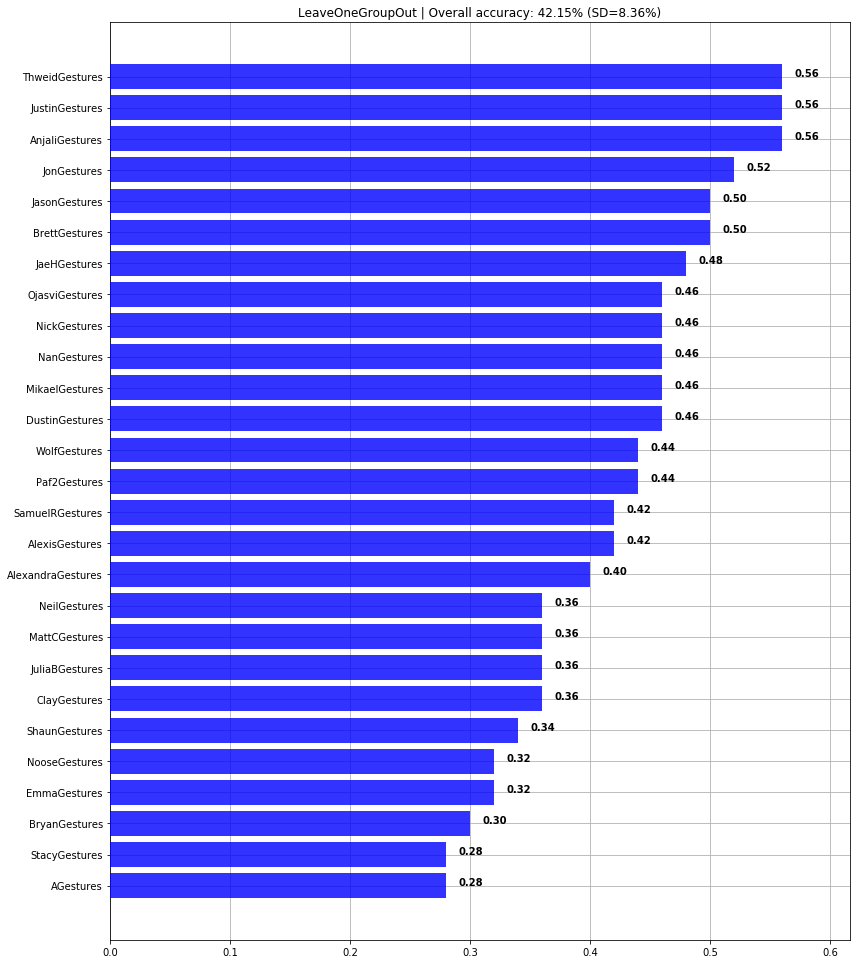

In [51]:
graph_title = f"LeaveOneGroupOut | Overall accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)"
plot_bar_graph(map_gesture_set_name_to_score, title=graph_title)

### Using Scikit-learn's LeaveOneGroupOut

Now, let's use Scikit-learn's built-in [`LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) approach. Because `LeaveOneGroupOut` requires integer categories to describe groups (rather than strings), we will need to do just a bit of setup. Thankfully, Pandas has built-in support to convert strings to category codes automatically. So, we will do this first and then rely on `LeaveOneGroupOut` to do all the hard work for us.

And because we built a manual implemention above, we can use that as a quick sanity check to confirm that our results are as expected. Just make sure you're using the same classifier and normalization.

In [52]:
from sklearn.model_selection import LeaveOneGroupOut

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values(),
                                                                              include_custom_gesture=False)

# Convert into a DataFrame and drop trial_num as a feature
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")

# Add in a nominal (integer) category column for gesturer, since
# LeaveOneGroupOut creates groups based on integers rather than strings
df["gesturer"] = df["gesturer"].astype('category')
df["gesturer_cat"] = df["gesturer"].cat.codes

# Print out number of unique gestures
print(f"Num unique gestures: {df['gesture'].nunique()}")
print(f"The gestures: {df['gesture'].unique()}")
      
# Setup the input DataFrames to Sci-kit learn
X = df
y = df.pop('gesture')
      
print(f"LeaveOneGroupOut will create {LeaveOneGroupOut().get_n_splits(X, y, groups = df['gesturer_cat'])} splits")

# Remove gesturer and gesturer_cat as input features
gesturer = df.pop('gesturer')
group_by_gesturer_cat = df.pop("gesturer_cat")

# Setup classifier and normalization
clf = svm.SVC(kernel='linear') # again, change this to the model + parameters that you want
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

scores = cross_val_score(pipeline, X, y, cv = LeaveOneGroupOut().split(X, y, groups = group_by_gesturer_cat))
print("Raw scores:", scores)

print()
print(f"Overall accuracy: {np.mean(scores) * 100:0.2f}% (SD={np.std(scores) * 100:0.2f})%")
print("-----")
      
# loop through names + scores. Scores are in same order as group_by_gesturer_cat
# Looping through category codes, from: https://stackoverflow.com/a/51102402
map_cat_code_to_gesturer = dict(enumerate(gesturer.cat.categories))
map_gesturer_to_score = dict()
for cat_code, gesturer_name in map_cat_code_to_gesturer.items():
    print(f"{gesturer_name}: {scores[cat_code] * 100:0.2f}%")
    map_gesturer_to_score[gesturer_name] = scores[cat_code]



Num unique gestures: 10
The gestures: ["Midair 'S'" 'Forehand Tennis' 'Shake' "Midair Clockwise 'O'"
 'Underhand Bowling' 'Baseball Throw' "Midair Zorro 'Z'"
 "Midair Counter-clockwise 'O'" 'Backhand Tennis' 'At Rest']
LeaveOneGroupOut will create 27 splits
Raw scores: [0.28 0.4  0.42 0.56 0.5  0.3  0.36 0.46 0.32 0.48 0.5  0.52 0.36 0.56
 0.36 0.46 0.46 0.36 0.46 0.32 0.46 0.44 0.42 0.34 0.28 0.56 0.44]

Overall accuracy: 42.15% (SD=8.36)%
-----
AGestures: 28.00%
AlexandraGestures: 40.00%
AlexisGestures: 42.00%
AnjaliGestures: 56.00%
BrettGestures: 50.00%
BryanGestures: 30.00%
ClayGestures: 36.00%
DustinGestures: 46.00%
EmmaGestures: 32.00%
JaeHGestures: 48.00%
JasonGestures: 50.00%
JonGestures: 52.00%
JuliaBGestures: 36.00%
JustinGestures: 56.00%
MattCGestures: 36.00%
MikaelGestures: 46.00%
NanGestures: 46.00%
NeilGestures: 36.00%
NickGestures: 46.00%
NooseGestures: 32.00%
OjasviGestures: 46.00%
Paf2Gestures: 44.00%
SamuelRGestures: 42.00%
ShaunGestures: 34.00%
StacyGestures: 28.00%


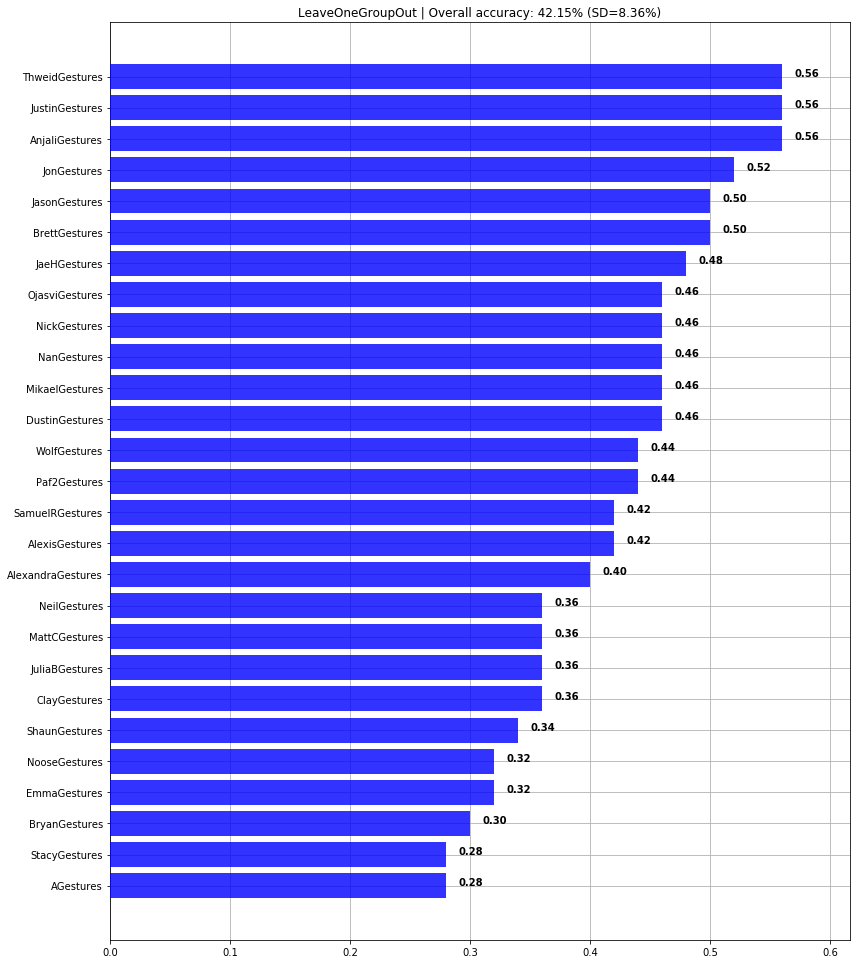

In [53]:
graph_title = f"LeaveOneGroupOut | Overall accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)"
plot_bar_graph(map_gesture_set_name_to_score, title=graph_title)

And, indeed, both our manual implementation and using Scikit-learn's [`LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) provide the same result.

But using [`LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) also makes it easier to use all of Scikit-learn's extensive performance metrics. For example:

Overall SVM accuracy: 42.15%
                              precision    recall  f1-score   support

                     At Rest       1.00      0.99      1.00       135
             Backhand Tennis       0.14      0.09      0.11       135
              Baseball Throw       0.37      0.44      0.41       135
             Forehand Tennis       0.20      0.15      0.17       135
                  Midair 'S'       0.49      0.55      0.52       135
        Midair Clockwise 'O'       0.34      0.25      0.29       135
Midair Counter-clockwise 'O'       0.40      0.59      0.48       135
            Midair Zorro 'Z'       0.31      0.30      0.31       135
                       Shake       0.43      0.50      0.46       135
           Underhand Bowling       0.36      0.36      0.36       135

                    accuracy                           0.42      1350
                   macro avg       0.40      0.42      0.41      1350
                weighted avg       0.40      0.42      0.41

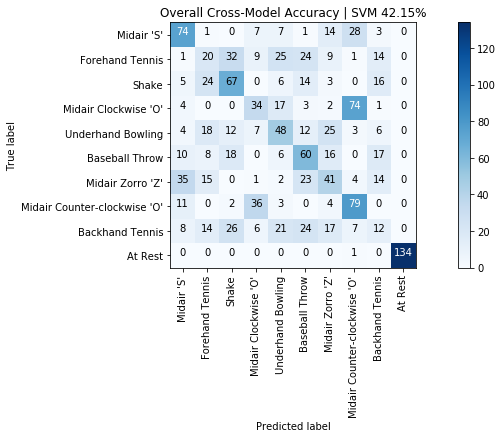

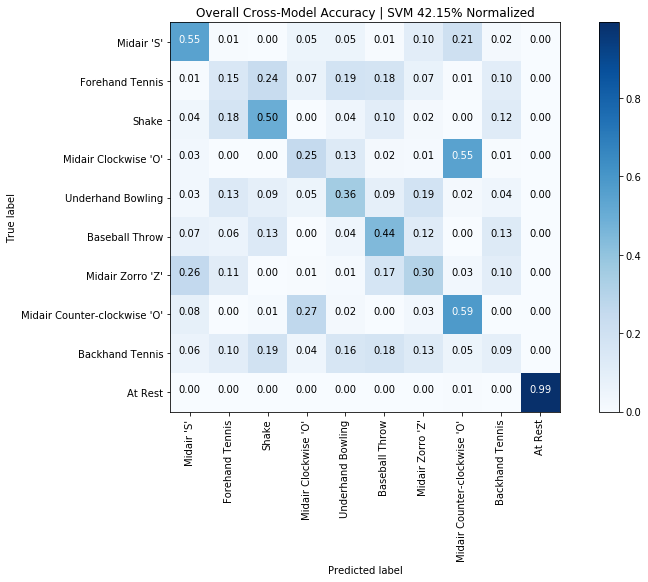

In [54]:
y_pred = cross_val_predict(pipeline, X, y, cv = LeaveOneGroupOut().split(X, y, groups = group_by_gesturer_cat))
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=y.unique())
graph_title = f"Overall Cross-Model Accuracy | SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=y.unique(), title=graph_title, normalize=False)

grvis.plot_confusion_matrix(cm, classes=y.unique(), title=graph_title + " Normalized", normalize=True, figsize=(12,8))

## Second model: leave one gesture trial out

In this second model, we assume that the "test" user provides some initial training data—perhaps during a calibration phase when they first get the accelerometer-based input controller. We will train on **all** data from **all** users except for a single set of trials from the test user.

### Run on just one gesture set for illustrative purposes

In [55]:
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values(),
                                                                              include_custom_gesture=False)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# Select the test gesture set. For example, "EmmaGestures" or "JonGestures"
just_test_gesturer = df.loc[df['gesturer'] == "JonGestures"]
print(f"Selected {just_test_gesturer['gesturer'].iloc[0]} for testing")
test_df = pd.DataFrame()
drop_indices = []

# Extract 1 random gesture trial for each gesture class in the test gesture set
# The test DataFrame will be test_df
print("The randomly selected test trials:")
for gesture_name in gesture_set.GESTURE_NAMES_WITHOUT_CUSTOM:
    just_gesture = just_test_gesturer.loc[df['gesture'] == gesture_name]
    random_gesture_trial = just_gesture.sample(1, random_state=None) # change random state to an int to control random seed
    selected_trial_num = random_gesture_trial['trial_num'].iloc[0]
    print(f"  '{gesture_name}' Selected trial num: {selected_trial_num} at DataFrame index {random_gesture_trial.index[0]}")
    drop_indices.append(random_gesture_trial.index[0])
    test_df = test_df.append(random_gesture_trial)

# We don't want trial number or gesturer as an input feature, so remove them
trial_indices = df.pop("trial_num")
gesturer = df.pop('gesturer')
test_df.pop('gesturer')
test_df.pop('trial_num')
    
# Setup training and test DataFrames
training_df = df.drop(drop_indices)
X_train = training_df
y_train = training_df.pop('gesture')
X_test = test_df
y_test = test_df.pop('gesture')

# Scale data first
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Score
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("----")
print(f"Classification accuracy: {score * 100:.2f}%")

Selected JonGestures for testing
The randomly selected test trials:
  'Midair 'S'' Selected trial num: 1 at DataFrame index 551
  'Forehand Tennis' Selected trial num: 0 at DataFrame index 555
  'Shake' Selected trial num: 2 at DataFrame index 562
  'Midair Clockwise 'O'' Selected trial num: 4 at DataFrame index 569
  'Underhand Bowling' Selected trial num: 1 at DataFrame index 571
  'Baseball Throw' Selected trial num: 3 at DataFrame index 578
  'Midair Zorro 'Z'' Selected trial num: 0 at DataFrame index 580
  'Midair Counter-clockwise 'O'' Selected trial num: 3 at DataFrame index 588
  'Backhand Tennis' Selected trial num: 0 at DataFrame index 590
  'At Rest' Selected trial num: 0 at DataFrame index 595
----
Classification accuracy: 60.00%


### Using k-fold cross validation on one gesture set

If you rerun the cell above, you're likely to get vastly different classification results based on which gestures were randomly selected for test. So, instead, let's use [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) and run train and test on five different folds of the selected test set's data. This will provide a more robust evaluation of our model.

In [56]:
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values(),
                                                                              include_custom_gesture=False)

df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num")

# Select the test gesture set. For example, "EmmaGestures" or "JonGestures"
just_test_gesturer = df.loc[df['gesturer'] == "JonGestures"]
print(f"Selected {just_test_gesturer['gesturer'].iloc[0]} for testing")
just_test_gesturer_y_true = just_test_gesturer.pop('gesture')
just_test_gesturer.pop('gesturer')
gesturer = df.pop('gesturer')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = None)
scores = []
for train_index, test_index in skf.split(just_test_gesturer, just_test_gesturer_y_true):
    
    # The training set is everything but the test indices for this fold
    df_training = df.drop(test_index)
      
    # Setup the training and test DataFrames
    X_train = df_training
    y_train = df_training.pop('gesture')
    X_test = just_test_gesturer.iloc[test_index]
    y_test = just_test_gesturer_y_true.iloc[test_index]

    # Scale data first
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Score
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

    print(f" Fold: {len(scores)} Score: {score:.3f}")
      
print("----")
print(f"Overall accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)")

Selected JonGestures for testing
 Fold: 1 Score: 0.600
 Fold: 2 Score: 0.400
 Fold: 3 Score: 0.600
 Fold: 4 Score: 0.500
 Fold: 5 Score: 0.500
----
Overall accuracy: 52.00% (SD=7.48%)


### Leave-one-gesture-out cross validation
Let's put it all together and run the cross validation on each gesture set.

In [57]:
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values(),
                                                                              include_custom_gesture=False)

map_gesturer_scores = dict()
verbose = False
for test_gesture_set in map_gesture_sets.values():
    if verbose:
        print(f"Testing gesture set: {test_gesture_set.name}")
    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
    trial_indices = df.pop("trial_num")
    
    just_test_gesturer = df.loc[df['gesturer'] == test_gesture_set.name]
    just_test_gesturer_y_true = just_test_gesturer.pop('gesture')
    just_test_gesturer.pop('gesturer')
    gesturer = df.pop('gesturer')

    # Remember, if you want to control the same splits across different runs
    # Set random_state to an integer (which will set the random seed)
    # This is really important if you are trying to evaluate how different
    # features, models, and parameters compare
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
    scores = []
    for train_index, test_index in skf.split(just_test_gesturer, just_test_gesturer_y_true):
        # The training set is everything but the test indices for this fold
        df_training = df.drop(test_index)

        # Setup the training and test DataFrames
        X_train = df_training
        y_train = df_training.pop('gesture')
        X_test = just_test_gesturer.iloc[test_index]
        y_test = just_test_gesturer_y_true.iloc[test_index]

        # Scale data first
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Score
        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
        
        if verbose:
            print(f" Fold: {len(scores)} Score: {score:.3f}")

    map_gesturer_scores[test_gesture_set.name] = scores

map_gesturer_avg_score = dict()
avg_scores = []
for gesturer_name, scores in map_gesturer_scores.items():
    print(f"{gesturer_name}: {np.mean(scores) * 100:0.2f}% (SD={np.std(scores) * 100:0.2f})%")
    
    map_gesturer_avg_score[gesturer_name] = np.mean(scores)

avg_score = np.mean(list(map_gesturer_avg_score.values())) * 100
std_score = np.std(list(map_gesturer_avg_score.values())) * 100
print("-----")
print(f"Overall accuracy: {avg_score:0.2f}% (SD={std_score:0.2f}%)")

AGestures: 28.00% (SD=7.48)%
AlexandraGestures: 46.00% (SD=13.56)%
AlexisGestures: 42.00% (SD=11.66)%
AnjaliGestures: 72.00% (SD=7.48)%
BrettGestures: 50.00% (SD=0.00)%
BryanGestures: 38.00% (SD=9.80)%
ClayGestures: 36.00% (SD=4.90)%
DustinGestures: 48.00% (SD=7.48)%
EmmaGestures: 38.00% (SD=9.80)%
JaeHGestures: 54.00% (SD=12.00)%
JasonGestures: 50.00% (SD=6.32)%
JonGestures: 52.00% (SD=7.48)%
JuliaBGestures: 40.00% (SD=0.00)%
JustinGestures: 62.00% (SD=13.27)%
MattCGestures: 38.00% (SD=4.00)%
MikaelGestures: 48.00% (SD=4.00)%
NanGestures: 52.00% (SD=7.48)%
NeilGestures: 42.00% (SD=7.48)%
NickGestures: 50.00% (SD=8.94)%
NooseGestures: 30.00% (SD=0.00)%
OjasviGestures: 48.00% (SD=4.00)%
Paf2Gestures: 44.00% (SD=8.00)%
SamuelRGestures: 44.00% (SD=12.00)%
ShaunGestures: 38.00% (SD=7.48)%
StacyGestures: 26.00% (SD=10.20)%
ThweidGestures: 56.00% (SD=4.90)%
WolfGestures: 46.00% (SD=4.90)%
-----
Overall accuracy: 45.11% (SD=9.85%)


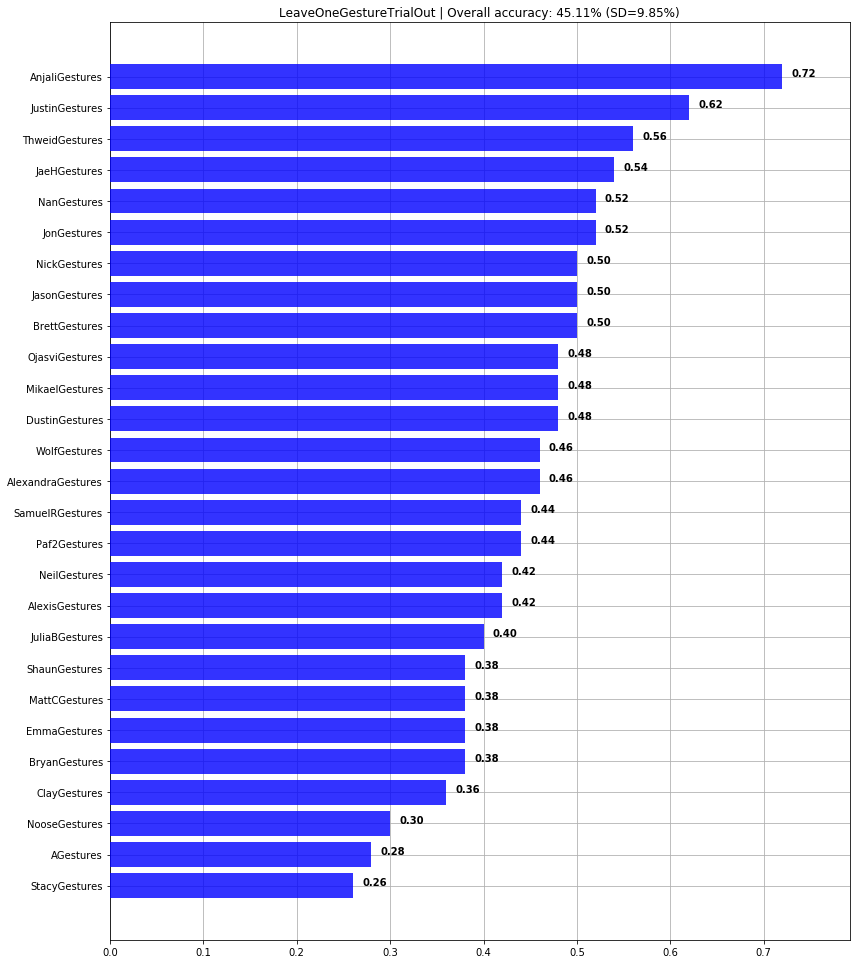

In [58]:
graph_title = f"LeaveOneGestureTrialOut | Overall accuracy: {avg_score:0.2f}% (SD={std_score:0.2f}%)"
plot_bar_graph(map_gesturer_avg_score, title=graph_title)